### Data Exploration

data description: Penn Tree Bank (PTB) dataset Marcus et al.(1993), which consists of 929k training words, 73k validation words, and 82k test words. It has 10k words in its vocabulary.


In [ ]:
# prompt: download ./PTB/ folder from drive

import os
import shutil
from google.colab import drive, files

drive.mount('/content/drive')
source_path = '/content/drive/MyDrive/Deep Learning/PTB'
# Specify the destination path on your Colab environment
destination_path = "/content/PTB"

# Create the destination folder if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

for filename in os.listdir(source_path):
  source_file_path = os.path.join(source_path, filename)
  destination_file_path = os.path.join(destination_path, filename)
  shutil.copy(source_file_path, destination_file_path)

#dismount
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
with open('/content/PTB/ptb.train.txt', 'rb') as h:
  train_txt = h.read()

with open('/content/PTB/ptb.valid.txt', 'rb') as h:
  valid_txt = h.read()

with open('/content/PTB/ptb.test.txt', 'rb') as h:
  test_txt = h.read()

In [ ]:
print(type(train_txt))

<class 'bytes'>


In [ ]:
# turn .txt into strings:
train_str = train_txt.decode('utf-8').strip()
valid_str = valid_txt.decode('utf-8').strip()
test_str = test_txt.decode('utf-8').strip()

In [ ]:
print("train length:", len(train_str))
print("valid length:", len(valid_str))
print("test length:", len(test_str))

train_txt[:1000]

train length: 5101615
valid length: 399779
test length: 449942


b' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter \n pierre <unk> N years old will join the board as a nonexecutive director nov. N \n mr. <unk> is chairman of <unk> n.v. the dutch publishing group \n rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate \n a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported \n the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said \n <unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in its <unk> cigarette filters in N \n although preliminary fin

### Data Preprocessing

In [ ]:
# replace \n with <eos>
train_str = train_str.replace('\n','<eos>')
valid_str = valid_str.replace('\n','<eos>')
test_str = test_str.replace('\n','<eos>')

In [ ]:
from collections import Counter

# Creating word2int and int2word dictionaries
all_txt = train_str + valid_str + test_str
txt_words = all_txt.split()
word_counts = Counter(txt_words).most_common()
word2int = {w:ii for ii, (w,c) in enumerate(word_counts)}
int2word = {ii:w for w, ii in word2int.items()}

print(word_counts[:10])
print(len(word2int))

[('the', 59421), ('<unk>', 53298), ('<eos>', 49196), ('N', 37606), ('of', 28427), ('to', 27430), ('a', 24755), ('in', 21032), ('and', 20404), ("'s", 11555)]
10002


In [ ]:
import numpy as np
# Encoding words as integers
encoded_train = np.array([word2int[w] for w in train_str.split()])
encoded_valid = np.array([word2int[w] for w in valid_str.split()])
encoded_test = np.array([word2int[w] for w in test_str.split()])

# Asserting equality between encoded data to original data
print(encoded_train[:10])
decoded_attempt = ' '.join([str(int2word[w]) for w in encoded_train[:10]])
print(decoded_attempt)
print(train_str[:len(decoded_attempt)])

[6503 6151 7924 8539 2353 8540 6918 8541 8542 7394]
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec


In [ ]:
# Creating labels
train_labels = np.append(encoded_train[1:],word2int['<eos>'])
valid_labels = np.append(encoded_valid[1:],word2int['<eos>'])
test_labels = np.append(encoded_test[1:],word2int['<eos>'])



# created a bug:
# test_labels = [encoded_test[1:]] + [word2int['<eos>']]

print("First 10 instances in train \ labels")
print(encoded_train[:10])
print(train_labels[:10])
print()

print("Last 2 instances in train \ labels")
print(encoded_train[-2:])
print(train_labels[-2:])
print()

print("Length of encoded_train, train_labels")
print(len(encoded_train))
print(len(train_labels))

First 10 instances in train \ labels
[6503 6151 7924 8539 2353 8540 6918 8541 8542 7394]
[6151 7924 8539 2353 8540 6918 8541 8542 7394 7925]

Last 2 instances in train \ labels
[23  1]
[1 2]

Length of encoded_train, train_labels
929588
929588


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, x_input,labels, seq_length, batch_size):
        self.x_input = x_input
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.num_batches = len(x_input) // seq_length
        self.stride = len(x_input) // batch_size  # How far apart starting points are for batches
        self.labels = labels


    def __len__(self):
        return self.num_batches  # One sequence per batch

    def __getitem__(self, idx):
        # print("__getitem__ call number: ", idx)
        # Calculate the start of the sequence for this batch
        start_idx = (((idx%self.batch_size)) * self.stride) + (idx//batch_size)*(self.seq_length)
        # Get the sequence
        input_sequence = self.x_input[start_idx:start_idx + self.seq_length]
        label_sequence = self.labels[start_idx:start_idx + self.seq_length]
        sequence = (input_sequence, label_sequence)

        return sequence

In [ ]:
# To imitate the behavior described using torch.optim.lr_scheduler.CosineAnnealingLR, you need to carefully adjust its parameters. However, the behavior you're describing is a custom exponential decay rather than a cosine annealing schedule. To simulate this using PyTorch, you may want to use a custom learning rate scheduler instead.
# Here’s how you can implement the described behavior:

# 1. Using torch.optim.lr_scheduler.LambdaLR
# The LambdaLR scheduler allows you to define a custom learning rate schedule as a lambda function.

import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR

# Example optimizer
model = torch.nn.Linear(10, 1)  # Dummy model
optimizer = SGD(model.parameters(), lr=1.0)  # Initial LR = 1.0

# Define the custom learning rate decay function
def lr_lambda(epoch):
    if epoch <= 6:
        return 1.0  # No change for the first 6 epochs
    else:
        return (1.0 / (1.5 ** (epoch - 6)))  # Decrease by factor of 1.5 per epoch after epoch 6

# Use LambdaLR
scheduler = LambdaLR(optimizer, lr_lambda)

# Simulate training loop
for epoch in range(40):
    # Training step (placeholder)
    optimizer.step()

    # Print current learning rate
    print(f"Epoch {epoch + 1}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Step the scheduler
    scheduler.step()

Epoch 1, LR: 1.000000
Epoch 2, LR: 1.000000
Epoch 3, LR: 1.000000
Epoch 4, LR: 1.000000
Epoch 5, LR: 1.000000
Epoch 6, LR: 1.000000
Epoch 7, LR: 1.000000
Epoch 8, LR: 0.666667
Epoch 9, LR: 0.444444
Epoch 10, LR: 0.296296
Epoch 11, LR: 0.197531
Epoch 12, LR: 0.131687
Epoch 13, LR: 0.087791
Epoch 14, LR: 0.058528
Epoch 15, LR: 0.039018
Epoch 16, LR: 0.026012
Epoch 17, LR: 0.017342
Epoch 18, LR: 0.011561
Epoch 19, LR: 0.007707
Epoch 20, LR: 0.005138
Epoch 21, LR: 0.003425
Epoch 22, LR: 0.002284
Epoch 23, LR: 0.001522
Epoch 24, LR: 0.001015
Epoch 25, LR: 0.000677
Epoch 26, LR: 0.000451
Epoch 27, LR: 0.000301
Epoch 28, LR: 0.000200
Epoch 29, LR: 0.000134
Epoch 30, LR: 0.000089
Epoch 31, LR: 0.000059
Epoch 32, LR: 0.000040
Epoch 33, LR: 0.000026
Epoch 34, LR: 0.000018
Epoch 35, LR: 0.000012
Epoch 36, LR: 0.000008
Epoch 37, LR: 0.000005
Epoch 38, LR: 0.000003
Epoch 39, LR: 0.000002
Epoch 40, LR: 0.000002


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os

class hw2LSTM(nn.Module):

    # reason: in the Penn Treebank (PTB) dataset, it is common to treat the text
    # as a single continuous stream of words when training language models

    def __init__(self, batch_size,seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p, device, rnn_type = "LSTM",checkpoint = None):
        super(hw2LSTM, self).__init__()  # Pass the current class and self
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_p, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout=dropout_p, batch_first=True)

        self.fc = nn.Linear(hidden_dim,vocab_size)

        self.apply(self.init_weights)
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.embedding_dim = embedding_dim
        self.dropout_p = dropout_p
        self.device = device
        self.rnn_type = rnn_type

        if checkpoint is not None:
            print("Loading checkpoint...")
            checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))
            self.load_state_dict(checkpoint)
            self.to(device)
            print("Checkpoint loaded successfully.")



    def init_weights(self,m):
        # LSTM parameters are initialized uniformly in [−0.05, 0.05].
         if type(m) == nn.LSTM or type(m) == nn.GRU:
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param.data, -0.05, 0.05)
                elif 'bias' in name:
                    nn.init.constant_(param.data, 0) # convention


    def forward(self,x,hidden):
        embedded = self.embedding(x) # batch_size*seq_length,embedding
        embedded = self.dropout(embedded)
        out, hidden = self.rnn(embedded, hidden) # batch_size, seq_length, hidden_dim
        out = out.contiguous().view(-1,self.hidden_dim) # batch_size*seq_length , hidden_dim
        out = self.fc(out) # batch_size*seq_length , vocab_size
        return out, hidden

def lr_lambda(epoch):
    if epoch <= 6:
        return 1.0  # No change for the first 6 epochs
    else:
        return (1.0 / (1.2 ** (epoch - 6)))  # Decrease by factor of 1.2 per epoch after epoch 6

def init_hidden(net, batch_size, n_layers, hidden_dim):
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")

    # hidden0 should tuple each in size (n_layers,batchsize,hidden_dim)
    weight = next(net.parameters()).data

    # If theres multiple seqs per batch
    if net.rnn_type == "LSTM":
    # Initialize hidden state as a tuple (h_t, c_t)
        hidden = (
        weight.new_zeros(n_layers, batch_size, hidden_dim).to(device),
        weight.new_zeros(n_layers, batch_size, hidden_dim).to(device),
      )
    elif net.rnn_type == "GRU":
    # Initialize hidden state as a single tensor
        hidden = weight.new_zeros(n_layers, batch_size, hidden_dim).to(device)

    return hidden

def train(model,train_x,train_y,val_x,val_y,batch_size,learning_rate, n_epoches, clip,validate_and_print_every,model_name):
    count = 0
    best_valid_perplexity = float('inf')

    # checkpoints
    checkpoint_dir = f'Perplexity_Comparasion_RNN/models/checkpoints/{model_name}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Zero accumulated gradients
    model.zero_grad()

    # Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lr_lambda)


    train_dataset = SequenceDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), model.seq_length, batch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # use device
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)

    # Loss & Perplexity
    per_epoch_train_losses = []
    per_epoch_train_perplexities = []
    per_epoch_valid_losses = []
    per_epoch_valid_perplexities = []

    # epoch_loop
    for epoch in tqdm(range(n_epoches)):
      model.train()
      valid_losses = []
      valid_perplexities = []

      # batch_loop
      # Initiate hidden once. Afterwards - the final hidden states of the current minibatch
      # is used as the initial hidden state of the subsequent minibatch
      hidden = init_hidden(model,batch_size,model.n_layers,model.hidden_dim)

      # batch_loop
      for inputs, labels in train_loader:
          count += 1

          # Throw last batch
          # if inputs.shape[0] != batch_size or labels.shape[0] != batch_size:
          #       continue  # Skip this batch if it's smaller

          model.zero_grad()


          inputs, labels = inputs.to(device), labels.to(device)
          if model.rnn_type == "LSTM":
            hidden = tuple([each.detach() for each in hidden])
          elif model.rnn_type == "GRU":
            hidden = hidden.detach()
          out, hidden = model(inputs,hidden)
          labels = labels.view(-1)
          loss = criterion(out, labels)
          loss.backward()
          # We clip the norm of the gradients (normalized by minibatch size) at 5.
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          # Note - I couldnt find if clip_grad_norm_ normalizes the gradients internally by batch_size.
          optimizer.step()

          if count % validate_and_print_every == 0:
            ###
            train_perplexity = torch.exp(loss).item()
            ###
            print("Epoch: {}/{}...".format(epoch+1, n_epoches),
                "Step: {}...".format(count),
                "Loss: {:.4f}...".format(loss.item()),
                "Last train batch Perplexity: {:.4f}...".format(train_perplexity))
                # "Avarage val Loss: {:.4f}...".format(valid_loss/len(val_loader)),
                # "Avarage val Perplexity: {:.4f}".format(average_valid_perplexity))

      # Validation
      model.eval()

      valid_losses = []
      valid_perplexities_avarage = []
      val_h = init_hidden(model,batch_size,model.n_layers,model.hidden_dim)
      val_dataset = SequenceDataset(torch.from_numpy(val_x), torch.from_numpy(val_y), model.seq_length, batch_size)
      val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

      # Iterate throught validation data
      for inputs, labels in val_loader:
          # if inputs.shape[0] != batch_size or labels.shape[0] != batch_size:
          #     continue
          if model.rnn_type == "LSTM":
            val_h = tuple([each.detach() for each in val_h])
          elif model.rnn_type == "GRU":
            val_h = val_h.detach()
          inputs, labels = inputs.to(device), labels.to(device)
          out, val_h = model(inputs, val_h)
          labels = labels.view(-1)
          val_loss = criterion(out, labels)
          valid_losses.append(val_loss.item())

          valid_perplexity = torch.exp(val_loss).item()
          valid_perplexities_avarage.append(valid_perplexity)

      # valid_losses.append(valid_loss/len(val_loader))
      avarage_valid_loss = sum(valid_losses)/len(valid_losses)
      average_valid_perplexity = sum(valid_perplexities_avarage)/len(valid_perplexities_avarage)
      valid_perplexities.append(average_valid_perplexity)

      # Iterate through train data
      epoch_train_losses = []
      epoch_train_perplexities = []
      hidden = init_hidden(model,batch_size,model.n_layers,model.hidden_dim)
      for inputs, labels in train_loader:
          if model.rnn_type == "LSTM":
            hidden = tuple([each.detach() for each in hidden])
          elif model.rnn_type == "GRU":
            hidden = hidden.detach()
          inputs, labels = inputs.to(device), labels.to(device)
          out, hidden = model(inputs, hidden)
          labels = labels.view(-1)
          loss = criterion(out, labels)
          epoch_train_losses.append(loss.item())
          epoch_train_perplexity = torch.exp(loss).item()
          epoch_train_perplexities.append(epoch_train_perplexity)

      avarage_train_loss = sum(epoch_train_losses)/len(epoch_train_losses)
      avarage_train_perplexity = sum(epoch_train_perplexities)/len(epoch_train_perplexities)
      model.train()

      if average_valid_perplexity < best_valid_perplexity:
        best_valid_perplexity = average_valid_perplexity
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_validation_model.pt'))

      tqdm.write(
                f'Epoch: {epoch + 1:02}, Train Loss: {avarage_train_loss:.3f}, Valid Loss: {avarage_valid_loss:.3f}, Train Perplexity: {avarage_train_perplexity:.3f}, Valid Perplexity: {average_valid_perplexity:.3f}')

      per_epoch_train_losses.append(avarage_train_loss)
      per_epoch_train_perplexities.append(avarage_train_perplexity)
      per_epoch_valid_losses.append(avarage_valid_loss)
      per_epoch_valid_perplexities.append(average_valid_perplexity)
    return per_epoch_train_losses, per_epoch_valid_losses, per_epoch_train_perplexities, per_epoch_valid_perplexities


In [ ]:
hidden_dim = 200
embedding_dim = 512
batch_size = 20
dropout_p = 0.3
learning_rate = 1
clip = 3
print_every = 300
vocab_size = len(word2int)
print(vocab_size)
n_layers = 2
n_epoches = 40
seq_length = 35

10002


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "LSTM_dropout_0.3"
lstm_model = hw2LSTM(batch_size,seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p, device)
per_epoch_train_losses, per_epoch_valid_losses, per_epoch_train_perplexities, per_epoch_valid_perplexities = train(model= lstm_model, train_x= encoded_train,train_y=train_labels,val_x = encoded_valid, val_y = valid_labels,batch_size= batch_size,learning_rate= learning_rate, n_epoches= n_epoches, clip= clip, validate_and_print_every= print_every,model_name=model_name)
# train(lstm_model,x,y,batch_size,learning_rate, n_epoches, clip

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40... Step: 300... Loss: 6.3997... Last train batch Perplexity: 601.6764...
Epoch: 1/40... Step: 600... Loss: 6.2827... Last train batch Perplexity: 535.2275...
Epoch: 1/40... Step: 900... Loss: 6.0616... Last train batch Perplexity: 429.0668...
Epoch: 1/40... Step: 1200... Loss: 5.4043... Last train batch Perplexity: 222.3631...


  2%|▎         | 1/40 [00:14<09:19, 14.35s/it]

Epoch: 01, Train Loss: 5.869, Valid Loss: 5.871, Train Perplexity: 358.748, Valid Perplexity: 359.033
Epoch: 2/40... Step: 1500... Loss: 5.7397... Last train batch Perplexity: 310.9570...
Epoch: 2/40... Step: 1800... Loss: 5.6660... Last train batch Perplexity: 288.8789...
Epoch: 2/40... Step: 2100... Loss: 5.4901... Last train batch Perplexity: 242.2782...
Epoch: 2/40... Step: 2400... Loss: 5.3772... Last train batch Perplexity: 216.4198...


  5%|▌         | 2/40 [00:27<08:48, 13.90s/it]

Epoch: 02, Train Loss: 5.531, Valid Loss: 5.569, Train Perplexity: 256.586, Valid Perplexity: 265.659
Epoch: 3/40... Step: 2700... Loss: 5.4815... Last train batch Perplexity: 240.2069...
Epoch: 3/40... Step: 3000... Loss: 5.6842... Last train batch Perplexity: 294.1968...
Epoch: 3/40... Step: 3300... Loss: 5.5390... Last train batch Perplexity: 254.4256...
Epoch: 3/40... Step: 3600... Loss: 5.4545... Last train batch Perplexity: 233.8043...
Epoch: 3/40... Step: 3900... Loss: 5.6115... Last train batch Perplexity: 273.5451...


  8%|▊         | 3/40 [00:41<08:26, 13.68s/it]

Epoch: 03, Train Loss: 5.352, Valid Loss: 5.419, Train Perplexity: 214.734, Valid Perplexity: 228.896
Epoch: 4/40... Step: 4200... Loss: 5.2419... Last train batch Perplexity: 189.0203...
Epoch: 4/40... Step: 4500... Loss: 5.3916... Last train batch Perplexity: 219.5443...
Epoch: 4/40... Step: 4800... Loss: 5.2548... Last train batch Perplexity: 191.4902...
Epoch: 4/40... Step: 5100... Loss: 5.5326... Last train batch Perplexity: 252.7990...


 10%|█         | 4/40 [00:56<08:28, 14.13s/it]

Epoch: 04, Train Loss: 5.210, Valid Loss: 5.301, Train Perplexity: 186.520, Valid Perplexity: 203.566
Epoch: 5/40... Step: 5400... Loss: 5.1526... Last train batch Perplexity: 172.8790...
Epoch: 5/40... Step: 5700... Loss: 5.4054... Last train batch Perplexity: 222.5986...
Epoch: 5/40... Step: 6000... Loss: 5.0751... Last train batch Perplexity: 159.9928...
Epoch: 5/40... Step: 6300... Loss: 4.8701... Last train batch Perplexity: 130.3303...
Epoch: 5/40... Step: 6600... Loss: 5.3607... Last train batch Perplexity: 212.8747...


 12%|█▎        | 5/40 [01:10<08:21, 14.34s/it]

Epoch: 05, Train Loss: 5.111, Valid Loss: 5.225, Train Perplexity: 168.997, Valid Perplexity: 188.816
Epoch: 6/40... Step: 6900... Loss: 5.3232... Last train batch Perplexity: 205.0435...
Epoch: 6/40... Step: 7200... Loss: 4.7875... Last train batch Perplexity: 120.0061...
Epoch: 6/40... Step: 7500... Loss: 5.4841... Last train batch Perplexity: 240.8256...
Epoch: 6/40... Step: 7800... Loss: 5.0712... Last train batch Perplexity: 159.3615...


 15%|█▌        | 6/40 [01:26<08:18, 14.66s/it]

Epoch: 06, Train Loss: 5.033, Valid Loss: 5.166, Train Perplexity: 156.420, Valid Perplexity: 178.101
Epoch: 7/40... Step: 8100... Loss: 5.2496... Last train batch Perplexity: 190.4910...
Epoch: 7/40... Step: 8400... Loss: 5.0868... Last train batch Perplexity: 161.8724...
Epoch: 7/40... Step: 8700... Loss: 4.9422... Last train batch Perplexity: 140.0822...
Epoch: 7/40... Step: 9000... Loss: 4.9416... Last train batch Perplexity: 139.9934...


 18%|█▊        | 7/40 [01:41<08:05, 14.73s/it]

Epoch: 07, Train Loss: 4.968, Valid Loss: 5.120, Train Perplexity: 146.611, Valid Perplexity: 170.182
Epoch: 8/40... Step: 9300... Loss: 5.2533... Last train batch Perplexity: 191.1972...
Epoch: 8/40... Step: 9600... Loss: 4.8610... Last train batch Perplexity: 129.1567...
Epoch: 8/40... Step: 9900... Loss: 5.1465... Last train batch Perplexity: 171.8329...
Epoch: 8/40... Step: 10200... Loss: 5.2418... Last train batch Perplexity: 189.0158...
Epoch: 8/40... Step: 10500... Loss: 4.7936... Last train batch Perplexity: 120.7344...


 20%|██        | 8/40 [01:55<07:45, 14.55s/it]

Epoch: 08, Train Loss: 4.907, Valid Loss: 5.076, Train Perplexity: 138.065, Valid Perplexity: 162.856
Epoch: 9/40... Step: 10800... Loss: 5.1512... Last train batch Perplexity: 172.6317...
Epoch: 9/40... Step: 11100... Loss: 4.8036... Last train batch Perplexity: 121.9504...
Epoch: 9/40... Step: 11400... Loss: 5.0003... Last train batch Perplexity: 148.4651...
Epoch: 9/40... Step: 11700... Loss: 4.5891... Last train batch Perplexity: 98.4092...


 22%|██▎       | 9/40 [02:09<07:28, 14.47s/it]

Epoch: 09, Train Loss: 4.857, Valid Loss: 5.043, Train Perplexity: 131.281, Valid Perplexity: 157.600
Epoch: 10/40... Step: 12000... Loss: 4.9361... Last train batch Perplexity: 139.2242...
Epoch: 10/40... Step: 12300... Loss: 4.8518... Last train batch Perplexity: 127.9744...
Epoch: 10/40... Step: 12600... Loss: 5.2209... Last train batch Perplexity: 185.1025...
Epoch: 10/40... Step: 12900... Loss: 5.3544... Last train batch Perplexity: 211.5265...
Epoch: 10/40... Step: 13200... Loss: 4.8509... Last train batch Perplexity: 127.8587...


 25%|██▌       | 10/40 [02:23<07:08, 14.27s/it]

Epoch: 10, Train Loss: 4.812, Valid Loss: 5.014, Train Perplexity: 125.574, Valid Perplexity: 153.110
Epoch: 11/40... Step: 13500... Loss: 5.1197... Last train batch Perplexity: 167.2784...
Epoch: 11/40... Step: 13800... Loss: 4.9311... Last train batch Perplexity: 138.5282...
Epoch: 11/40... Step: 14100... Loss: 4.6581... Last train batch Perplexity: 105.4312...
Epoch: 11/40... Step: 14400... Loss: 4.7399... Last train batch Perplexity: 114.4202...


 28%|██▊       | 11/40 [02:37<06:50, 14.17s/it]

Epoch: 11, Train Loss: 4.768, Valid Loss: 4.990, Train Perplexity: 120.178, Valid Perplexity: 149.586
Epoch: 12/40... Step: 14700... Loss: 4.7843... Last train batch Perplexity: 119.6129...
Epoch: 12/40... Step: 15000... Loss: 4.6190... Last train batch Perplexity: 101.3945...
Epoch: 12/40... Step: 15300... Loss: 5.0623... Last train batch Perplexity: 157.9539...
Epoch: 12/40... Step: 15600... Loss: 5.1380... Last train batch Perplexity: 170.3757...
Epoch: 12/40... Step: 15900... Loss: 5.0041... Last train batch Perplexity: 149.0244...


 30%|███       | 12/40 [02:51<06:36, 14.15s/it]

Epoch: 12, Train Loss: 4.729, Valid Loss: 4.966, Train Perplexity: 115.675, Valid Perplexity: 146.049
Epoch: 13/40... Step: 16200... Loss: 4.9299... Last train batch Perplexity: 138.3718...
Epoch: 13/40... Step: 16500... Loss: 4.8052... Last train batch Perplexity: 122.1439...
Epoch: 13/40... Step: 16800... Loss: 4.8240... Last train batch Perplexity: 124.4583...
Epoch: 13/40... Step: 17100... Loss: 4.9929... Last train batch Perplexity: 147.3680...


 32%|███▎      | 13/40 [03:05<06:21, 14.14s/it]

Epoch: 13, Train Loss: 4.697, Valid Loss: 4.949, Train Perplexity: 112.032, Valid Perplexity: 143.618
Epoch: 14/40... Step: 17400... Loss: 5.0098... Last train batch Perplexity: 149.8772...
Epoch: 14/40... Step: 17700... Loss: 5.1049... Last train batch Perplexity: 164.8285...
Epoch: 14/40... Step: 18000... Loss: 4.8014... Last train batch Perplexity: 121.6794...
Epoch: 14/40... Step: 18300... Loss: 4.8187... Last train batch Perplexity: 123.8027...


 35%|███▌      | 14/40 [03:19<06:06, 14.10s/it]

Epoch: 14, Train Loss: 4.662, Valid Loss: 4.929, Train Perplexity: 108.117, Valid Perplexity: 140.707
Epoch: 15/40... Step: 18600... Loss: 4.9596... Last train batch Perplexity: 142.5423...
Epoch: 15/40... Step: 18900... Loss: 4.7416... Last train batch Perplexity: 114.6204...
Epoch: 15/40... Step: 19200... Loss: 4.7945... Last train batch Perplexity: 120.8479...
Epoch: 15/40... Step: 19500... Loss: 4.7720... Last train batch Perplexity: 118.1565...
Epoch: 15/40... Step: 19800... Loss: 4.5427... Last train batch Perplexity: 93.9467...


 38%|███▊      | 15/40 [03:33<05:52, 14.08s/it]

Epoch: 15, Train Loss: 4.632, Valid Loss: 4.913, Train Perplexity: 104.974, Valid Perplexity: 138.634
Epoch: 16/40... Step: 20100... Loss: 5.0124... Last train batch Perplexity: 150.2618...
Epoch: 16/40... Step: 20400... Loss: 5.1221... Last train batch Perplexity: 167.6934...
Epoch: 16/40... Step: 20700... Loss: 4.9360... Last train batch Perplexity: 139.2108...
Epoch: 16/40... Step: 21000... Loss: 4.5223... Last train batch Perplexity: 92.0445...


 40%|████      | 16/40 [03:48<05:40, 14.20s/it]

Epoch: 16, Train Loss: 4.607, Valid Loss: 4.901, Train Perplexity: 102.393, Valid Perplexity: 137.011
Epoch: 17/40... Step: 21300... Loss: 4.7614... Last train batch Perplexity: 116.9039...
Epoch: 17/40... Step: 21600... Loss: 4.4268... Last train batch Perplexity: 83.6656...
Epoch: 17/40... Step: 21900... Loss: 4.2651... Last train batch Perplexity: 71.1738...
Epoch: 17/40... Step: 22200... Loss: 4.9616... Last train batch Perplexity: 142.8189...
Epoch: 17/40... Step: 22500... Loss: 4.3269... Last train batch Perplexity: 75.7056...


 42%|████▎     | 17/40 [04:01<05:23, 14.09s/it]

Epoch: 17, Train Loss: 4.579, Valid Loss: 4.888, Train Perplexity: 99.630, Valid Perplexity: 135.251
Epoch: 18/40... Step: 22800... Loss: 4.7280... Last train batch Perplexity: 113.0719...
Epoch: 18/40... Step: 23100... Loss: 5.0967... Last train batch Perplexity: 163.4880...
Epoch: 18/40... Step: 23400... Loss: 4.8862... Last train batch Perplexity: 132.4483...
Epoch: 18/40... Step: 23700... Loss: 5.0167... Last train batch Perplexity: 150.9137...


 45%|████▌     | 18/40 [04:15<05:08, 14.01s/it]

Epoch: 18, Train Loss: 4.560, Valid Loss: 4.883, Train Perplexity: 97.776, Valid Perplexity: 134.587
Epoch: 19/40... Step: 24000... Loss: 4.6304... Last train batch Perplexity: 102.5576...
Epoch: 19/40... Step: 24300... Loss: 4.8177... Last train batch Perplexity: 123.6827...
Epoch: 19/40... Step: 24600... Loss: 4.8472... Last train batch Perplexity: 127.3781...
Epoch: 19/40... Step: 24900... Loss: 4.9874... Last train batch Perplexity: 146.5518...
Epoch: 19/40... Step: 25200... Loss: 4.9448... Last train batch Perplexity: 140.4462...


 48%|████▊     | 19/40 [04:29<04:53, 13.97s/it]

Epoch: 19, Train Loss: 4.535, Valid Loss: 4.871, Train Perplexity: 95.309, Valid Perplexity: 132.951
Epoch: 20/40... Step: 25500... Loss: 4.6757... Last train batch Perplexity: 107.3066...
Epoch: 20/40... Step: 25800... Loss: 4.9265... Last train batch Perplexity: 137.8928...
Epoch: 20/40... Step: 26100... Loss: 4.6919... Last train batch Perplexity: 109.0654...
Epoch: 20/40... Step: 26400... Loss: 4.5783... Last train batch Perplexity: 97.3474...


 50%|█████     | 20/40 [04:43<04:38, 13.94s/it]

Epoch: 20, Train Loss: 4.512, Valid Loss: 4.858, Train Perplexity: 93.171, Valid Perplexity: 131.317
Epoch: 21/40... Step: 26700... Loss: 4.8394... Last train batch Perplexity: 126.3914...
Epoch: 21/40... Step: 27000... Loss: 4.5426... Last train batch Perplexity: 93.9322...
Epoch: 21/40... Step: 27300... Loss: 3.8672... Last train batch Perplexity: 47.8096...
Epoch: 21/40... Step: 27600... Loss: 4.5322... Last train batch Perplexity: 92.9606...


 52%|█████▎    | 21/40 [04:57<04:24, 13.94s/it]

Epoch: 21, Train Loss: 4.494, Valid Loss: 4.851, Train Perplexity: 91.464, Valid Perplexity: 130.454
Epoch: 22/40... Step: 27900... Loss: 4.6448... Last train batch Perplexity: 104.0388...
Epoch: 22/40... Step: 28200... Loss: 4.6695... Last train batch Perplexity: 106.6497...
Epoch: 22/40... Step: 28500... Loss: 4.8273... Last train batch Perplexity: 124.8771...
Epoch: 22/40... Step: 28800... Loss: 4.9759... Last train batch Perplexity: 144.8784...
Epoch: 22/40... Step: 29100... Loss: 4.5992... Last train batch Perplexity: 99.4042...


 55%|█████▌    | 22/40 [05:11<04:11, 13.98s/it]

Epoch: 22, Train Loss: 4.475, Valid Loss: 4.845, Train Perplexity: 89.753, Valid Perplexity: 129.616
Epoch: 23/40... Step: 29400... Loss: 4.7846... Last train batch Perplexity: 119.6585...
Epoch: 23/40... Step: 29700... Loss: 4.9802... Last train batch Perplexity: 145.5048...
Epoch: 23/40... Step: 30000... Loss: 4.6759... Last train batch Perplexity: 107.3313...
Epoch: 23/40... Step: 30300... Loss: 4.8609... Last train batch Perplexity: 129.1340...


 57%|█████▊    | 23/40 [05:25<03:58, 14.00s/it]

Epoch: 23, Train Loss: 4.456, Valid Loss: 4.840, Train Perplexity: 88.055, Valid Perplexity: 129.047
Epoch: 24/40... Step: 30600... Loss: 4.4783... Last train batch Perplexity: 88.0844...
Epoch: 24/40... Step: 30900... Loss: 4.5547... Last train batch Perplexity: 95.0786...
Epoch: 24/40... Step: 31200... Loss: 4.6634... Last train batch Perplexity: 105.9995...
Epoch: 24/40... Step: 31500... Loss: 4.9468... Last train batch Perplexity: 140.7228...
Epoch: 24/40... Step: 31800... Loss: 4.6270... Last train batch Perplexity: 102.2107...


 60%|██████    | 24/40 [05:39<03:43, 14.00s/it]

Epoch: 24, Train Loss: 4.442, Valid Loss: 4.834, Train Perplexity: 86.901, Valid Perplexity: 128.363
Epoch: 25/40... Step: 32100... Loss: 4.5542... Last train batch Perplexity: 95.0299...
Epoch: 25/40... Step: 32400... Loss: 4.9843... Last train batch Perplexity: 146.1056...
Epoch: 25/40... Step: 32700... Loss: 4.4085... Last train batch Perplexity: 82.1466...
Epoch: 25/40... Step: 33000... Loss: 4.4524... Last train batch Perplexity: 85.8351...


 62%|██████▎   | 25/40 [05:53<03:29, 13.95s/it]

Epoch: 25, Train Loss: 4.421, Valid Loss: 4.823, Train Perplexity: 85.062, Valid Perplexity: 126.912
Epoch: 26/40... Step: 33300... Loss: 4.3898... Last train batch Perplexity: 80.6281...
Epoch: 26/40... Step: 33600... Loss: 4.7679... Last train batch Perplexity: 117.6708...
Epoch: 26/40... Step: 33900... Loss: 4.4286... Last train batch Perplexity: 83.8148...
Epoch: 26/40... Step: 34200... Loss: 4.3499... Last train batch Perplexity: 77.4672...
Epoch: 26/40... Step: 34500... Loss: 4.9829... Last train batch Perplexity: 145.8979...


 65%|██████▌   | 26/40 [06:07<03:14, 13.90s/it]

Epoch: 26, Train Loss: 4.408, Valid Loss: 4.824, Train Perplexity: 83.978, Valid Perplexity: 127.171
Epoch: 27/40... Step: 34800... Loss: 4.3492... Last train batch Perplexity: 77.4202...
Epoch: 27/40... Step: 35100... Loss: 4.9065... Last train batch Perplexity: 135.1672...
Epoch: 27/40... Step: 35400... Loss: 4.6767... Last train batch Perplexity: 107.4131...
Epoch: 27/40... Step: 35700... Loss: 4.1930... Last train batch Perplexity: 66.2180...


 68%|██████▊   | 27/40 [06:20<03:00, 13.88s/it]

Epoch: 27, Train Loss: 4.396, Valid Loss: 4.819, Train Perplexity: 82.996, Valid Perplexity: 126.534
Epoch: 28/40... Step: 36000... Loss: 4.7936... Last train batch Perplexity: 120.7332...
Epoch: 28/40... Step: 36300... Loss: 4.6944... Last train batch Perplexity: 109.3339...
Epoch: 28/40... Step: 36600... Loss: 4.4220... Last train batch Perplexity: 83.2667...
Epoch: 28/40... Step: 36900... Loss: 4.0568... Last train batch Perplexity: 57.7893...


 70%|███████   | 28/40 [06:34<02:46, 13.87s/it]

Epoch: 28, Train Loss: 4.378, Valid Loss: 4.810, Train Perplexity: 81.465, Valid Perplexity: 125.371
Epoch: 29/40... Step: 37200... Loss: 4.6490... Last train batch Perplexity: 104.4759...
Epoch: 29/40... Step: 37500... Loss: 4.6959... Last train batch Perplexity: 109.4954...
Epoch: 29/40... Step: 37800... Loss: 4.3452... Last train batch Perplexity: 77.1109...
Epoch: 29/40... Step: 38100... Loss: 4.7642... Last train batch Perplexity: 117.2327...
Epoch: 29/40... Step: 38400... Loss: 4.5974... Last train batch Perplexity: 99.2283...


 72%|███████▎  | 29/40 [06:48<02:32, 13.86s/it]

Epoch: 29, Train Loss: 4.367, Valid Loss: 4.808, Train Perplexity: 80.642, Valid Perplexity: 125.045
Epoch: 30/40... Step: 38700... Loss: 4.5407... Last train batch Perplexity: 93.7564...
Epoch: 30/40... Step: 39000... Loss: 4.5170... Last train batch Perplexity: 91.5630...
Epoch: 30/40... Step: 39300... Loss: 4.6632... Last train batch Perplexity: 105.9705...
Epoch: 30/40... Step: 39600... Loss: 4.6173... Last train batch Perplexity: 101.2230...


 75%|███████▌  | 30/40 [07:02<02:18, 13.86s/it]

Epoch: 30, Train Loss: 4.353, Valid Loss: 4.805, Train Perplexity: 79.499, Valid Perplexity: 124.696
Epoch: 31/40... Step: 39900... Loss: 4.1607... Last train batch Perplexity: 64.1133...
Epoch: 31/40... Step: 40200... Loss: 4.7577... Last train batch Perplexity: 116.4749...
Epoch: 31/40... Step: 40500... Loss: 4.6709... Last train batch Perplexity: 106.7958...
Epoch: 31/40... Step: 40800... Loss: 4.7767... Last train batch Perplexity: 118.7176...
Epoch: 31/40... Step: 41100... Loss: 4.6579... Last train batch Perplexity: 105.4118...


 78%|███████▊  | 31/40 [07:16<02:04, 13.88s/it]

Epoch: 31, Train Loss: 4.341, Valid Loss: 4.801, Train Perplexity: 78.569, Valid Perplexity: 124.293
Epoch: 32/40... Step: 41400... Loss: 4.6560... Last train batch Perplexity: 105.2112...
Epoch: 32/40... Step: 41700... Loss: 4.4872... Last train batch Perplexity: 88.8710...
Epoch: 32/40... Step: 42000... Loss: 4.6327... Last train batch Perplexity: 102.7870...
Epoch: 32/40... Step: 42300... Loss: 4.5943... Last train batch Perplexity: 98.9233...


 80%|████████  | 32/40 [07:30<01:51, 13.92s/it]

Epoch: 32, Train Loss: 4.325, Valid Loss: 4.795, Train Perplexity: 77.270, Valid Perplexity: 123.486
Epoch: 33/40... Step: 42600... Loss: 4.6439... Last train batch Perplexity: 103.9446...
Epoch: 33/40... Step: 42900... Loss: 4.5200... Last train batch Perplexity: 91.8345...
Epoch: 33/40... Step: 43200... Loss: 4.2745... Last train batch Perplexity: 71.8431...
Epoch: 33/40... Step: 43500... Loss: 3.9091... Last train batch Perplexity: 49.8516...


 82%|████████▎ | 33/40 [07:44<01:37, 13.96s/it]

Epoch: 33, Train Loss: 4.313, Valid Loss: 4.791, Train Perplexity: 76.354, Valid Perplexity: 123.036
Epoch: 34/40... Step: 43800... Loss: 4.6500... Last train batch Perplexity: 104.5849...
Epoch: 34/40... Step: 44100... Loss: 4.1993... Last train batch Perplexity: 66.6385...
Epoch: 34/40... Step: 44400... Loss: 4.5227... Last train batch Perplexity: 92.0850...
Epoch: 34/40... Step: 44700... Loss: 4.3750... Last train batch Perplexity: 79.4378...
Epoch: 34/40... Step: 45000... Loss: 4.0065... Last train batch Perplexity: 54.9557...


 85%|████████▌ | 34/40 [07:58<01:23, 13.96s/it]

Epoch: 34, Train Loss: 4.299, Valid Loss: 4.786, Train Perplexity: 75.300, Valid Perplexity: 122.410
Epoch: 35/40... Step: 45300... Loss: 4.7104... Last train batch Perplexity: 111.0994...
Epoch: 35/40... Step: 45600... Loss: 4.1809... Last train batch Perplexity: 65.4245...
Epoch: 35/40... Step: 45900... Loss: 4.4371... Last train batch Perplexity: 84.5304...
Epoch: 35/40... Step: 46200... Loss: 4.0862... Last train batch Perplexity: 59.5129...


 88%|████████▊ | 35/40 [08:12<01:09, 13.89s/it]

Epoch: 35, Train Loss: 4.290, Valid Loss: 4.788, Train Perplexity: 74.680, Valid Perplexity: 122.684
Epoch: 36/40... Step: 46500... Loss: 4.5034... Last train batch Perplexity: 90.3214...
Epoch: 36/40... Step: 46800... Loss: 4.5560... Last train batch Perplexity: 95.2025...
Epoch: 36/40... Step: 47100... Loss: 4.4379... Last train batch Perplexity: 84.5979...
Epoch: 36/40... Step: 47400... Loss: 4.5191... Last train batch Perplexity: 91.7486...
Epoch: 36/40... Step: 47700... Loss: 4.3508... Last train batch Perplexity: 77.5417...


 90%|█████████ | 36/40 [08:25<00:55, 13.86s/it]

Epoch: 36, Train Loss: 4.282, Valid Loss: 4.790, Train Perplexity: 74.042, Valid Perplexity: 122.953
Epoch: 37/40... Step: 48000... Loss: 4.6467... Last train batch Perplexity: 104.2385...
Epoch: 37/40... Step: 48300... Loss: 4.3271... Last train batch Perplexity: 75.7206...
Epoch: 37/40... Step: 48600... Loss: 4.2514... Last train batch Perplexity: 70.2020...
Epoch: 37/40... Step: 48900... Loss: 4.5904... Last train batch Perplexity: 98.5305...


 92%|█████████▎| 37/40 [08:39<00:41, 13.86s/it]

Epoch: 37, Train Loss: 4.266, Valid Loss: 4.781, Train Perplexity: 72.911, Valid Perplexity: 121.911
Epoch: 38/40... Step: 49200... Loss: 4.1522... Last train batch Perplexity: 63.5749...
Epoch: 38/40... Step: 49500... Loss: 4.3370... Last train batch Perplexity: 76.4745...
Epoch: 38/40... Step: 49800... Loss: 4.5744... Last train batch Perplexity: 96.9676...
Epoch: 38/40... Step: 50100... Loss: 4.5129... Last train batch Perplexity: 91.1870...
Epoch: 38/40... Step: 50400... Loss: 4.6625... Last train batch Perplexity: 105.8954...


 95%|█████████▌| 38/40 [08:53<00:27, 13.86s/it]

Epoch: 38, Train Loss: 4.259, Valid Loss: 4.780, Train Perplexity: 72.372, Valid Perplexity: 121.783
Epoch: 39/40... Step: 50700... Loss: 4.7332... Last train batch Perplexity: 113.6536...
Epoch: 39/40... Step: 51000... Loss: 4.0107... Last train batch Perplexity: 55.1835...
Epoch: 39/40... Step: 51300... Loss: 4.3879... Last train batch Perplexity: 80.4715...
Epoch: 39/40... Step: 51600... Loss: 4.3433... Last train batch Perplexity: 76.9574...


 98%|█████████▊| 39/40 [09:07<00:13, 13.86s/it]

Epoch: 39, Train Loss: 4.250, Valid Loss: 4.779, Train Perplexity: 71.742, Valid Perplexity: 121.651
Epoch: 40/40... Step: 51900... Loss: 4.5819... Last train batch Perplexity: 97.7006...
Epoch: 40/40... Step: 52200... Loss: 4.2361... Last train batch Perplexity: 69.1407...
Epoch: 40/40... Step: 52500... Loss: 4.1158... Last train batch Perplexity: 61.3023...
Epoch: 40/40... Step: 52800... Loss: 4.1888... Last train batch Perplexity: 65.9453...


100%|██████████| 40/40 [09:21<00:00, 14.03s/it]

Epoch: 40, Train Loss: 4.241, Valid Loss: 4.777, Train Perplexity: 71.076, Valid Perplexity: 121.491


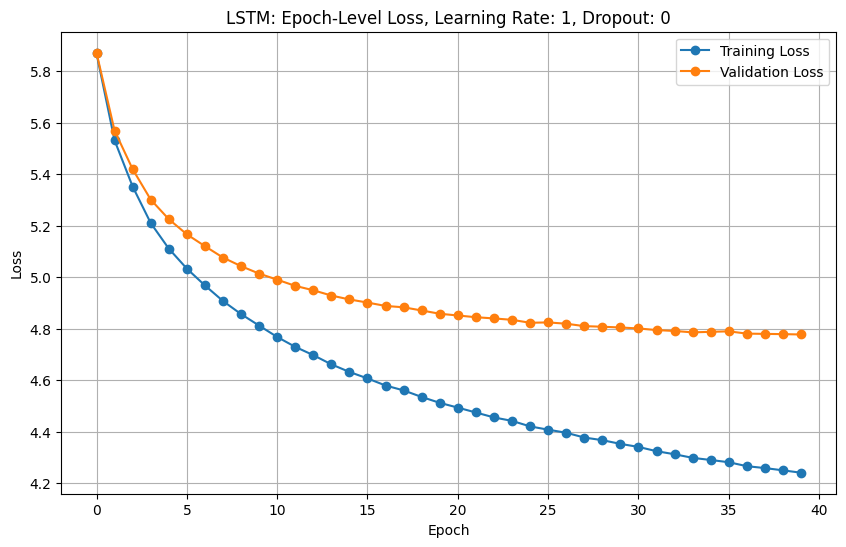

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, learning_rate, dropout, loss_or_preplexity = "Loss", model_type = "LSTM"):
    """
    Plots training and validation losses.

    Parameters:
        train_losses (list of list): Training losses for each batch in each epoch.
        val_losses (list of list): Validation losses for each batch in each epoch.
        batch_level (bool): If True, plot batch-level losses. Otherwise, plot epoch-level losses.
    """
    # Compute epoch-level losses by averaging
    # train_epoch_losses = [sum(epoch) / len(epoch) for epoch in train_losses]
    # val_epoch_losses = [sum(epoch) / len(epoch) for epoch in val_losses]

    # Plot epoch-level losses
    plt.figure(figsize=(10, 6))
    # plt.plot(train_epoch_losses[2:], label='Training Loss', marker='o')
    # plt.plot(val_epoch_losses[2:], label='Validation Loss', marker='o')
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel(loss_or_preplexity)
    plt.title(f'{model_type}: Epoch-Level {loss_or_preplexity}, Learning Rate: {learning_rate}, Dropout: {dropout}')

    plt.legend()
    plt.grid()
    plt.show()

# print("train_losses: ", len(train_losses[0]))
# print("valid_losses: ", len(valid_losses[0]))

plot_losses(per_epoch_train_losses, per_epoch_valid_losses, learning_rate= learning_rate, dropout= dropout_p)

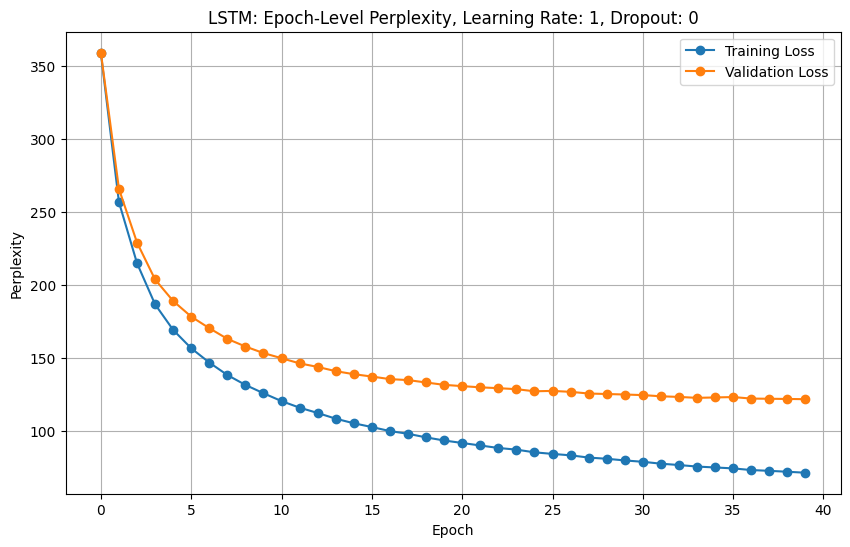

In [ ]:
plot_losses(per_epoch_train_perplexities, per_epoch_valid_perplexities, learning_rate= learning_rate, dropout= dropout_p,loss_or_preplexity = "Perplexity")

In [ ]:
# plot_losses(per_epoch_train_losses, per_epoch_valid_losses, batch_level=True)

In [ ]:
dropout_p = 0
model_name = "LSTM_no_dropout"

lstm = hw2LSTM(batch_size,seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p,device)
no_dropout = train(model= lstm, train_x= encoded_train,train_y=train_labels,val_x = encoded_valid, val_y = valid_labels,batch_size= batch_size,learning_rate= learning_rate, n_epoches= n_epoches, clip= clip, validate_and_print_every= print_every,model_name=model_name)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40... Step: 300... Loss: 6.3678... Last train batch Perplexity: 582.7689...
Epoch: 1/40... Step: 600... Loss: 6.2986... Last train batch Perplexity: 543.8055...
Epoch: 1/40... Step: 900... Loss: 6.0102... Last train batch Perplexity: 407.5753...
Epoch: 1/40... Step: 1200... Loss: 5.3090... Last train batch Perplexity: 202.1533...


  2%|▎         | 1/40 [00:13<08:57, 13.79s/it]

Epoch: 01, Train Loss: 5.777, Valid Loss: 5.787, Train Perplexity: 327.587, Valid Perplexity: 329.919
Epoch: 2/40... Step: 1500... Loss: 5.6365... Last train batch Perplexity: 280.4834...
Epoch: 2/40... Step: 1800... Loss: 5.5505... Last train batch Perplexity: 257.3558...
Epoch: 2/40... Step: 2100... Loss: 5.3453... Last train batch Perplexity: 209.6237...
Epoch: 2/40... Step: 2400... Loss: 5.2006... Last train batch Perplexity: 181.3811...


  5%|▌         | 2/40 [00:27<08:47, 13.88s/it]

Epoch: 02, Train Loss: 5.403, Valid Loss: 5.473, Train Perplexity: 226.114, Valid Perplexity: 241.481
Epoch: 3/40... Step: 2700... Loss: 5.3187... Last train batch Perplexity: 204.1163...
Epoch: 3/40... Step: 3000... Loss: 5.4804... Last train batch Perplexity: 239.9388...
Epoch: 3/40... Step: 3300... Loss: 5.3057... Last train batch Perplexity: 201.4814...
Epoch: 3/40... Step: 3600... Loss: 5.2337... Last train batch Perplexity: 187.4773...
Epoch: 3/40... Step: 3900... Loss: 5.3617... Last train batch Perplexity: 213.0946...


  8%|▊         | 3/40 [00:41<08:35, 13.93s/it]

Epoch: 03, Train Loss: 5.184, Valid Loss: 5.315, Train Perplexity: 181.871, Valid Perplexity: 206.319
Epoch: 4/40... Step: 4200... Loss: 5.0289... Last train batch Perplexity: 152.7616...
Epoch: 4/40... Step: 4500... Loss: 5.1323... Last train batch Perplexity: 169.4141...
Epoch: 4/40... Step: 4800... Loss: 4.9850... Last train batch Perplexity: 146.2027...
Epoch: 4/40... Step: 5100... Loss: 5.2901... Last train batch Perplexity: 198.3623...


 10%|█         | 4/40 [00:55<08:21, 13.93s/it]

Epoch: 04, Train Loss: 5.024, Valid Loss: 5.210, Train Perplexity: 155.109, Valid Perplexity: 186.093
Epoch: 5/40... Step: 5400... Loss: 4.8539... Last train batch Perplexity: 128.2381...
Epoch: 5/40... Step: 5700... Loss: 5.1256... Last train batch Perplexity: 168.2743...
Epoch: 5/40... Step: 6000... Loss: 4.8127... Last train batch Perplexity: 123.0614...
Epoch: 5/40... Step: 6300... Loss: 4.5799... Last train batch Perplexity: 97.5024...
Epoch: 5/40... Step: 6600... Loss: 5.0541... Last train batch Perplexity: 156.6591...


 12%|█▎        | 5/40 [01:09<08:05, 13.88s/it]

Epoch: 05, Train Loss: 4.899, Valid Loss: 5.144, Train Perplexity: 136.974, Valid Perplexity: 174.320
Epoch: 6/40... Step: 6900... Loss: 4.9904... Last train batch Perplexity: 147.0009...
Epoch: 6/40... Step: 7200... Loss: 4.4516... Last train batch Perplexity: 85.7607...
Epoch: 6/40... Step: 7500... Loss: 5.1413... Last train batch Perplexity: 170.9302...
Epoch: 6/40... Step: 7800... Loss: 4.8340... Last train batch Perplexity: 125.7090...


 15%|█▌        | 6/40 [01:23<07:50, 13.84s/it]

Epoch: 06, Train Loss: 4.799, Valid Loss: 5.100, Train Perplexity: 124.033, Valid Perplexity: 166.981
Epoch: 7/40... Step: 8100... Loss: 4.9061... Last train batch Perplexity: 135.1099...
Epoch: 7/40... Step: 8400... Loss: 4.7536... Last train batch Perplexity: 115.9977...
Epoch: 7/40... Step: 8700... Loss: 4.5259... Last train batch Perplexity: 92.3752...
Epoch: 7/40... Step: 9000... Loss: 4.5586... Last train batch Perplexity: 95.4512...


 18%|█▊        | 7/40 [01:36<07:35, 13.81s/it]

Epoch: 07, Train Loss: 4.704, Valid Loss: 5.065, Train Perplexity: 112.957, Valid Perplexity: 161.250
Epoch: 8/40... Step: 9300... Loss: 4.8483... Last train batch Perplexity: 127.5207...
Epoch: 8/40... Step: 9600... Loss: 4.4379... Last train batch Perplexity: 84.6003...
Epoch: 8/40... Step: 9900... Loss: 4.7468... Last train batch Perplexity: 115.2145...
Epoch: 8/40... Step: 10200... Loss: 4.8582... Last train batch Perplexity: 128.7980...
Epoch: 8/40... Step: 10500... Loss: 4.3750... Last train batch Perplexity: 79.4408...


 20%|██        | 8/40 [01:50<07:21, 13.81s/it]

Epoch: 08, Train Loss: 4.624, Valid Loss: 5.043, Train Perplexity: 104.342, Valid Perplexity: 157.788
Epoch: 9/40... Step: 10800... Loss: 4.7572... Last train batch Perplexity: 116.4219...
Epoch: 9/40... Step: 11100... Loss: 4.4383... Last train batch Perplexity: 84.6289...
Epoch: 9/40... Step: 11400... Loss: 4.5938... Last train batch Perplexity: 98.8648...
Epoch: 9/40... Step: 11700... Loss: 4.2318... Last train batch Perplexity: 68.8398...


 22%|██▎       | 9/40 [02:04<07:08, 13.83s/it]

Epoch: 09, Train Loss: 4.557, Valid Loss: 5.029, Train Perplexity: 97.575, Valid Perplexity: 155.691
Epoch: 10/40... Step: 12000... Loss: 4.4550... Last train batch Perplexity: 86.0583...
Epoch: 10/40... Step: 12300... Loss: 4.3643... Last train batch Perplexity: 78.5930...
Epoch: 10/40... Step: 12600... Loss: 4.7375... Last train batch Perplexity: 114.1473...
Epoch: 10/40... Step: 12900... Loss: 4.9543... Last train batch Perplexity: 141.7874...
Epoch: 10/40... Step: 13200... Loss: 4.4025... Last train batch Perplexity: 81.6532...


 25%|██▌       | 10/40 [02:18<06:54, 13.82s/it]

Epoch: 10, Train Loss: 4.496, Valid Loss: 5.022, Train Perplexity: 91.822, Valid Perplexity: 154.773
Epoch: 11/40... Step: 13500... Loss: 4.6792... Last train batch Perplexity: 107.6797...
Epoch: 11/40... Step: 13800... Loss: 4.5886... Last train batch Perplexity: 98.3571...
Epoch: 11/40... Step: 14100... Loss: 4.1667... Last train batch Perplexity: 64.5025...
Epoch: 11/40... Step: 14400... Loss: 4.2511... Last train batch Perplexity: 70.1854...


 28%|██▊       | 11/40 [02:32<06:39, 13.78s/it]

Epoch: 11, Train Loss: 4.443, Valid Loss: 5.023, Train Perplexity: 87.175, Valid Perplexity: 155.097
Epoch: 12/40... Step: 14700... Loss: 4.3127... Last train batch Perplexity: 74.6445...
Epoch: 12/40... Step: 15000... Loss: 4.2096... Last train batch Perplexity: 67.3319...
Epoch: 12/40... Step: 15300... Loss: 4.5865... Last train batch Perplexity: 98.1489...
Epoch: 12/40... Step: 15600... Loss: 4.6226... Last train batch Perplexity: 101.7564...
Epoch: 12/40... Step: 15900... Loss: 4.5022... Last train batch Perplexity: 90.2134...


 30%|███       | 12/40 [02:45<06:25, 13.78s/it]

Epoch: 12, Train Loss: 4.396, Valid Loss: 5.029, Train Perplexity: 83.208, Valid Perplexity: 155.980
Epoch: 13/40... Step: 16200... Loss: 4.4593... Last train batch Perplexity: 86.4263...
Epoch: 13/40... Step: 16500... Loss: 4.3034... Last train batch Perplexity: 73.9532...
Epoch: 13/40... Step: 16800... Loss: 4.2963... Last train batch Perplexity: 73.4274...
Epoch: 13/40... Step: 17100... Loss: 4.5172... Last train batch Perplexity: 91.5796...


 32%|███▎      | 13/40 [02:59<06:12, 13.81s/it]

Epoch: 13, Train Loss: 4.351, Valid Loss: 5.035, Train Perplexity: 79.590, Valid Perplexity: 157.077
Epoch: 14/40... Step: 17400... Loss: 4.5700... Last train batch Perplexity: 96.5409...
Epoch: 14/40... Step: 17700... Loss: 4.5311... Last train batch Perplexity: 92.8581...
Epoch: 14/40... Step: 18000... Loss: 4.1092... Last train batch Perplexity: 60.8982...
Epoch: 14/40... Step: 18300... Loss: 4.2615... Last train batch Perplexity: 70.9133...


 35%|███▌      | 14/40 [03:13<06:00, 13.87s/it]

Epoch: 14, Train Loss: 4.309, Valid Loss: 5.041, Train Perplexity: 76.332, Valid Perplexity: 158.023
Epoch: 15/40... Step: 18600... Loss: 4.3950... Last train batch Perplexity: 81.0458...
Epoch: 15/40... Step: 18900... Loss: 4.2004... Last train batch Perplexity: 66.7106...
Epoch: 15/40... Step: 19200... Loss: 4.2676... Last train batch Perplexity: 71.3504...
Epoch: 15/40... Step: 19500... Loss: 4.1465... Last train batch Perplexity: 63.2112...
Epoch: 15/40... Step: 19800... Loss: 4.0395... Last train batch Perplexity: 56.7975...


 38%|███▊      | 15/40 [03:27<05:46, 13.85s/it]

Epoch: 15, Train Loss: 4.273, Valid Loss: 5.051, Train Perplexity: 73.688, Valid Perplexity: 159.603
Epoch: 16/40... Step: 20100... Loss: 4.4799... Last train batch Perplexity: 88.2270...
Epoch: 16/40... Step: 20400... Loss: 4.6059... Last train batch Perplexity: 100.0707...
Epoch: 16/40... Step: 20700... Loss: 4.3566... Last train batch Perplexity: 77.9942...
Epoch: 16/40... Step: 21000... Loss: 3.9106... Last train batch Perplexity: 49.9283...


 40%|████      | 16/40 [03:41<05:31, 13.81s/it]

Epoch: 16, Train Loss: 4.246, Valid Loss: 5.064, Train Perplexity: 71.737, Valid Perplexity: 161.839
Epoch: 17/40... Step: 21300... Loss: 4.3267... Last train batch Perplexity: 75.6924...
Epoch: 17/40... Step: 21600... Loss: 3.9053... Last train batch Perplexity: 49.6661...
Epoch: 17/40... Step: 21900... Loss: 3.6969... Last train batch Perplexity: 40.3219...
Epoch: 17/40... Step: 22200... Loss: 4.3797... Last train batch Perplexity: 79.8154...
Epoch: 17/40... Step: 22500... Loss: 3.8233... Last train batch Perplexity: 45.7571...


 42%|████▎     | 17/40 [03:55<05:16, 13.78s/it]

Epoch: 17, Train Loss: 4.213, Valid Loss: 5.075, Train Perplexity: 69.419, Valid Perplexity: 163.648
Epoch: 18/40... Step: 22800... Loss: 4.1040... Last train batch Perplexity: 60.5816...
Epoch: 18/40... Step: 23100... Loss: 4.4523... Last train batch Perplexity: 85.8271...
Epoch: 18/40... Step: 23400... Loss: 4.3225... Last train batch Perplexity: 75.3766...
Epoch: 18/40... Step: 23700... Loss: 4.3485... Last train batch Perplexity: 77.3596...


 45%|████▌     | 18/40 [04:08<05:02, 13.75s/it]

Epoch: 18, Train Loss: 4.187, Valid Loss: 5.087, Train Perplexity: 67.619, Valid Perplexity: 165.842
Epoch: 19/40... Step: 24000... Loss: 4.0562... Last train batch Perplexity: 57.7541...
Epoch: 19/40... Step: 24300... Loss: 4.1662... Last train batch Perplexity: 64.4724...
Epoch: 19/40... Step: 24600... Loss: 4.1921... Last train batch Perplexity: 66.1596...
Epoch: 19/40... Step: 24900... Loss: 4.4331... Last train batch Perplexity: 84.1961...
Epoch: 19/40... Step: 25200... Loss: 4.3576... Last train batch Perplexity: 78.0703...


 48%|████▊     | 19/40 [04:22<04:48, 13.73s/it]

Epoch: 19, Train Loss: 4.155, Valid Loss: 5.099, Train Perplexity: 65.561, Valid Perplexity: 167.798
Epoch: 20/40... Step: 25500... Loss: 4.0457... Last train batch Perplexity: 57.1502...
Epoch: 20/40... Step: 25800... Loss: 4.2365... Last train batch Perplexity: 69.1619...
Epoch: 20/40... Step: 26100... Loss: 4.0977... Last train batch Perplexity: 60.2041...
Epoch: 20/40... Step: 26400... Loss: 3.9483... Last train batch Perplexity: 51.8466...


 50%|█████     | 20/40 [04:36<04:34, 13.72s/it]

Epoch: 20, Train Loss: 4.128, Valid Loss: 5.109, Train Perplexity: 63.791, Valid Perplexity: 169.527
Epoch: 21/40... Step: 26700... Loss: 4.2987... Last train batch Perplexity: 73.6026...
Epoch: 21/40... Step: 27000... Loss: 3.9819... Last train batch Perplexity: 53.6197...
Epoch: 21/40... Step: 27300... Loss: 3.3625... Last train batch Perplexity: 28.8599...
Epoch: 21/40... Step: 27600... Loss: 3.8368... Last train batch Perplexity: 46.3756...


 52%|█████▎    | 21/40 [04:49<04:20, 13.72s/it]

Epoch: 21, Train Loss: 4.099, Valid Loss: 5.118, Train Perplexity: 62.015, Valid Perplexity: 171.194
Epoch: 22/40... Step: 27900... Loss: 4.0602... Last train batch Perplexity: 57.9879...
Epoch: 22/40... Step: 28200... Loss: 4.0841... Last train batch Perplexity: 59.3865...
Epoch: 22/40... Step: 28500... Loss: 4.2164... Last train batch Perplexity: 67.7894...
Epoch: 22/40... Step: 28800... Loss: 4.3657... Last train batch Perplexity: 78.7069...
Epoch: 22/40... Step: 29100... Loss: 4.0669... Last train batch Perplexity: 58.3765...


 55%|█████▌    | 22/40 [05:03<04:06, 13.71s/it]

Epoch: 22, Train Loss: 4.080, Valid Loss: 5.133, Train Perplexity: 60.841, Valid Perplexity: 173.693
Epoch: 23/40... Step: 29400... Loss: 4.1172... Last train batch Perplexity: 61.3852...
Epoch: 23/40... Step: 29700... Loss: 4.3612... Last train batch Perplexity: 78.3500...
Epoch: 23/40... Step: 30000... Loss: 4.0555... Last train batch Perplexity: 57.7141...
Epoch: 23/40... Step: 30300... Loss: 4.1377... Last train batch Perplexity: 62.6558...


 57%|█████▊    | 23/40 [05:17<03:53, 13.72s/it]

Epoch: 23, Train Loss: 4.054, Valid Loss: 5.147, Train Perplexity: 59.247, Valid Perplexity: 176.260
Epoch: 24/40... Step: 30600... Loss: 3.7362... Last train batch Perplexity: 41.9399...
Epoch: 24/40... Step: 30900... Loss: 3.8521... Last train batch Perplexity: 47.0914...
Epoch: 24/40... Step: 31200... Loss: 4.0154... Last train batch Perplexity: 55.4433...
Epoch: 24/40... Step: 31500... Loss: 4.3070... Last train batch Perplexity: 74.2159...
Epoch: 24/40... Step: 31800... Loss: 3.9202... Last train batch Perplexity: 50.4094...


 60%|██████    | 24/40 [05:31<03:40, 13.76s/it]

Epoch: 24, Train Loss: 4.026, Valid Loss: 5.155, Train Perplexity: 57.656, Valid Perplexity: 177.721
Epoch: 25/40... Step: 32100... Loss: 3.9401... Last train batch Perplexity: 51.4219...
Epoch: 25/40... Step: 32400... Loss: 4.1470... Last train batch Perplexity: 63.2448...
Epoch: 25/40... Step: 32700... Loss: 3.7935... Last train batch Perplexity: 44.4129...
Epoch: 25/40... Step: 33000... Loss: 3.7154... Last train batch Perplexity: 41.0762...


 62%|██████▎   | 25/40 [05:45<03:27, 13.82s/it]

Epoch: 25, Train Loss: 4.011, Valid Loss: 5.170, Train Perplexity: 56.766, Valid Perplexity: 180.336
Epoch: 26/40... Step: 33300... Loss: 3.7464... Last train batch Perplexity: 42.3664...
Epoch: 26/40... Step: 33600... Loss: 4.1017... Last train batch Perplexity: 60.4427...
Epoch: 26/40... Step: 33900... Loss: 3.7105... Last train batch Perplexity: 40.8757...
Epoch: 26/40... Step: 34200... Loss: 3.6333... Last train batch Perplexity: 37.8391...
Epoch: 26/40... Step: 34500... Loss: 4.3329... Last train batch Perplexity: 76.1682...


 65%|██████▌   | 26/40 [05:58<03:13, 13.84s/it]

Epoch: 26, Train Loss: 3.989, Valid Loss: 5.180, Train Perplexity: 55.533, Valid Perplexity: 182.126
Epoch: 27/40... Step: 34800... Loss: 3.7009... Last train batch Perplexity: 40.4819...
Epoch: 27/40... Step: 35100... Loss: 4.1787... Last train batch Perplexity: 65.2796...
Epoch: 27/40... Step: 35400... Loss: 4.0105... Last train batch Perplexity: 55.1742...
Epoch: 27/40... Step: 35700... Loss: 3.4686... Last train batch Perplexity: 32.0910...


 68%|██████▊   | 27/40 [06:12<02:59, 13.84s/it]

Epoch: 27, Train Loss: 3.974, Valid Loss: 5.198, Train Perplexity: 54.724, Valid Perplexity: 185.583
Epoch: 28/40... Step: 36000... Loss: 4.0603... Last train batch Perplexity: 57.9946...
Epoch: 28/40... Step: 36300... Loss: 4.0244... Last train batch Perplexity: 55.9445...
Epoch: 28/40... Step: 36600... Loss: 3.7475... Last train batch Perplexity: 42.4157...
Epoch: 28/40... Step: 36900... Loss: 3.4388... Last train batch Perplexity: 31.1488...


 70%|███████   | 28/40 [06:26<02:45, 13.81s/it]

Epoch: 28, Train Loss: 3.949, Valid Loss: 5.208, Train Perplexity: 53.400, Valid Perplexity: 187.561
Epoch: 29/40... Step: 37200... Loss: 3.9622... Last train batch Perplexity: 52.5717...
Epoch: 29/40... Step: 37500... Loss: 3.8954... Last train batch Perplexity: 49.1735...
Epoch: 29/40... Step: 37800... Loss: 3.6648... Last train batch Perplexity: 39.0472...
Epoch: 29/40... Step: 38100... Loss: 4.1167... Last train batch Perplexity: 61.3570...
Epoch: 29/40... Step: 38400... Loss: 3.9313... Last train batch Perplexity: 50.9737...


 72%|███████▎  | 29/40 [06:40<02:31, 13.78s/it]

Epoch: 29, Train Loss: 3.929, Valid Loss: 5.216, Train Perplexity: 52.316, Valid Perplexity: 189.184
Epoch: 30/40... Step: 38700... Loss: 3.8196... Last train batch Perplexity: 45.5860...
Epoch: 30/40... Step: 39000... Loss: 3.8311... Last train batch Perplexity: 46.1153...
Epoch: 30/40... Step: 39300... Loss: 3.8556... Last train batch Perplexity: 47.2591...
Epoch: 30/40... Step: 39600... Loss: 3.8992... Last train batch Perplexity: 49.3612...


 75%|███████▌  | 30/40 [06:53<02:17, 13.77s/it]

Epoch: 30, Train Loss: 3.914, Valid Loss: 5.233, Train Perplexity: 51.525, Valid Perplexity: 192.370
Epoch: 31/40... Step: 39900... Loss: 3.4796... Last train batch Perplexity: 32.4482...
Epoch: 31/40... Step: 40200... Loss: 3.9913... Last train batch Perplexity: 54.1228...
Epoch: 31/40... Step: 40500... Loss: 3.9180... Last train batch Perplexity: 50.3003...
Epoch: 31/40... Step: 40800... Loss: 4.0204... Last train batch Perplexity: 55.7229...
Epoch: 31/40... Step: 41100... Loss: 3.9433... Last train batch Perplexity: 51.5893...


 78%|███████▊  | 31/40 [07:07<02:03, 13.75s/it]

Epoch: 31, Train Loss: 3.887, Valid Loss: 5.239, Train Perplexity: 50.214, Valid Perplexity: 193.510
Epoch: 32/40... Step: 41400... Loss: 3.9387... Last train batch Perplexity: 51.3508...
Epoch: 32/40... Step: 41700... Loss: 3.7669... Last train batch Perplexity: 43.2471...
Epoch: 32/40... Step: 42000... Loss: 3.8326... Last train batch Perplexity: 46.1812...
Epoch: 32/40... Step: 42300... Loss: 3.8330... Last train batch Perplexity: 46.2018...


 80%|████████  | 32/40 [07:21<01:49, 13.75s/it]

Epoch: 32, Train Loss: 3.871, Valid Loss: 5.251, Train Perplexity: 49.420, Valid Perplexity: 195.857
Epoch: 33/40... Step: 42600... Loss: 3.9096... Last train batch Perplexity: 49.8772...
Epoch: 33/40... Step: 42900... Loss: 3.8524... Last train batch Perplexity: 47.1050...
Epoch: 33/40... Step: 43200... Loss: 3.6299... Last train batch Perplexity: 37.7072...
Epoch: 33/40... Step: 43500... Loss: 3.2086... Last train batch Perplexity: 24.7457...


 82%|████████▎ | 33/40 [07:35<01:36, 13.73s/it]

Epoch: 33, Train Loss: 3.849, Valid Loss: 5.257, Train Perplexity: 48.325, Valid Perplexity: 197.096
Epoch: 34/40... Step: 43800... Loss: 3.8685... Last train batch Perplexity: 47.8710...
Epoch: 34/40... Step: 44100... Loss: 3.4652... Last train batch Perplexity: 31.9815...
Epoch: 34/40... Step: 44400... Loss: 3.7788... Last train batch Perplexity: 43.7645...
Epoch: 34/40... Step: 44700... Loss: 3.7246... Last train batch Perplexity: 41.4526...
Epoch: 34/40... Step: 45000... Loss: 3.1162... Last train batch Perplexity: 22.5614...


 85%|████████▌ | 34/40 [07:48<01:22, 13.74s/it]

Epoch: 34, Train Loss: 3.833, Valid Loss: 5.270, Train Perplexity: 47.540, Valid Perplexity: 199.711
Epoch: 35/40... Step: 45300... Loss: 3.8934... Last train batch Perplexity: 49.0790...
Epoch: 35/40... Step: 45600... Loss: 3.5046... Last train batch Perplexity: 33.2683...
Epoch: 35/40... Step: 45900... Loss: 3.6153... Last train batch Perplexity: 37.1623...
Epoch: 35/40... Step: 46200... Loss: 3.3783... Last train batch Perplexity: 29.3200...


 88%|████████▊ | 35/40 [08:02<01:08, 13.77s/it]

Epoch: 35, Train Loss: 3.813, Valid Loss: 5.277, Train Perplexity: 46.656, Valid Perplexity: 201.255
Epoch: 36/40... Step: 46500... Loss: 3.7139... Last train batch Perplexity: 41.0149...
Epoch: 36/40... Step: 46800... Loss: 3.6994... Last train batch Perplexity: 40.4239...
Epoch: 36/40... Step: 47100... Loss: 3.7680... Last train batch Perplexity: 43.2918...
Epoch: 36/40... Step: 47400... Loss: 3.8450... Last train batch Perplexity: 46.7583...
Epoch: 36/40... Step: 47700... Loss: 3.6482... Last train batch Perplexity: 38.4044...


 90%|█████████ | 36/40 [08:16<00:55, 13.81s/it]

Epoch: 36, Train Loss: 3.796, Valid Loss: 5.289, Train Perplexity: 45.812, Valid Perplexity: 203.855
Epoch: 37/40... Step: 48000... Loss: 3.8134... Last train batch Perplexity: 45.3051...
Epoch: 37/40... Step: 48300... Loss: 3.5875... Last train batch Perplexity: 36.1438...
Epoch: 37/40... Step: 48600... Loss: 3.4608... Last train batch Perplexity: 31.8416...
Epoch: 37/40... Step: 48900... Loss: 3.7770... Last train batch Perplexity: 43.6840...


 92%|█████████▎| 37/40 [08:30<00:41, 13.83s/it]

Epoch: 37, Train Loss: 3.786, Valid Loss: 5.306, Train Perplexity: 45.376, Valid Perplexity: 207.405
Epoch: 38/40... Step: 49200... Loss: 3.4351... Last train batch Perplexity: 31.0349...
Epoch: 38/40... Step: 49500... Loss: 3.5781... Last train batch Perplexity: 35.8037...
Epoch: 38/40... Step: 49800... Loss: 3.8421... Last train batch Perplexity: 46.6251...
Epoch: 38/40... Step: 50100... Loss: 3.8354... Last train batch Perplexity: 46.3097...
Epoch: 38/40... Step: 50400... Loss: 3.7498... Last train batch Perplexity: 42.5132...


 95%|█████████▌| 38/40 [08:44<00:27, 13.80s/it]

Epoch: 38, Train Loss: 3.765, Valid Loss: 5.312, Train Perplexity: 44.469, Valid Perplexity: 208.617
Epoch: 39/40... Step: 50700... Loss: 3.9321... Last train batch Perplexity: 51.0134...
Epoch: 39/40... Step: 51000... Loss: 3.3172... Last train batch Perplexity: 27.5835...
Epoch: 39/40... Step: 51300... Loss: 3.6649... Last train batch Perplexity: 39.0534...
Epoch: 39/40... Step: 51600... Loss: 3.5773... Last train batch Perplexity: 35.7764...


 98%|█████████▊| 39/40 [08:57<00:13, 13.77s/it]

Epoch: 39, Train Loss: 3.752, Valid Loss: 5.328, Train Perplexity: 43.877, Valid Perplexity: 211.925
Epoch: 40/40... Step: 51900... Loss: 3.8364... Last train batch Perplexity: 46.3574...
Epoch: 40/40... Step: 52200... Loss: 3.5471... Last train batch Perplexity: 34.7115...
Epoch: 40/40... Step: 52500... Loss: 3.3140... Last train batch Perplexity: 27.4955...
Epoch: 40/40... Step: 52800... Loss: 3.3708... Last train batch Perplexity: 29.1027...


100%|██████████| 40/40 [09:11<00:00, 13.79s/it]

Epoch: 40, Train Loss: 3.738, Valid Loss: 5.336, Train Perplexity: 43.269, Valid Perplexity: 213.793


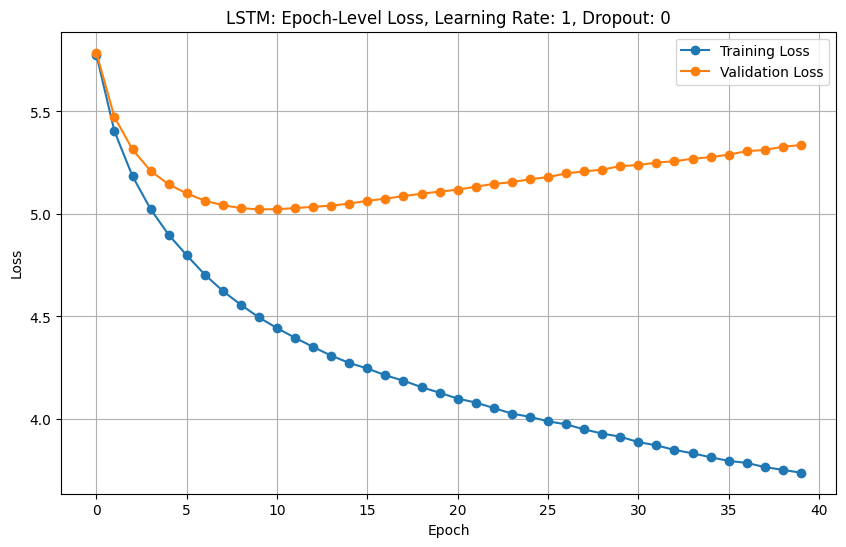

In [ ]:
plot_losses(no_dropout[0], no_dropout[1], learning_rate= learning_rate, dropout= dropout_p)

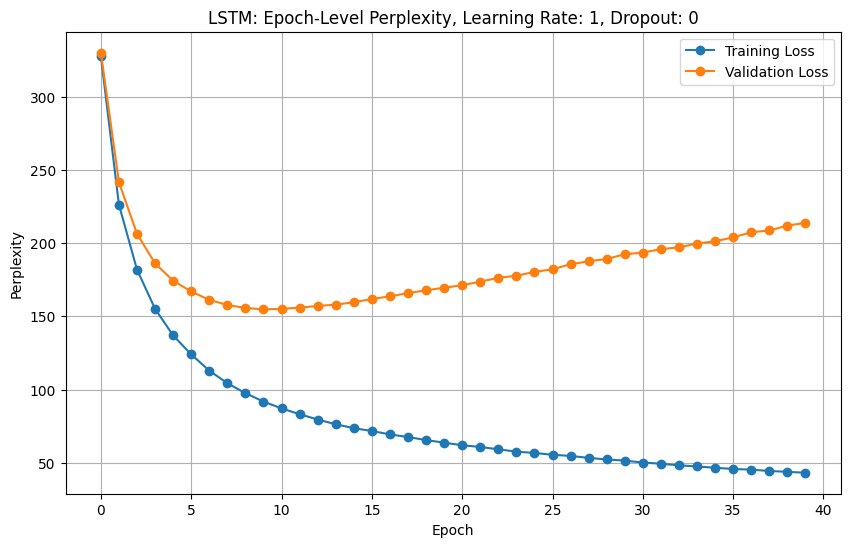

In [ ]:
plot_losses(no_dropout[2], no_dropout[3], learning_rate= learning_rate, dropout= dropout_p,loss_or_preplexity = "Perplexity")

יש לי באג ענק. הבאג הוא שהדאטה הוא אחד ארוך ואני צריך לחלק אותו לבאצ'ים. הקטע הוא שבאראןאן יש קונטקס שנמשך איתך קדימה, ולכן הבאצ'ים השונים צריכים לרוץ על תתי קטעים מהדאטה הענק, כלומר, צריך לחלק את הדאטה ל20 חלקים, ולכל אחד להגדיר סקוונס לנגט' כדי שהקונטקס יישמר

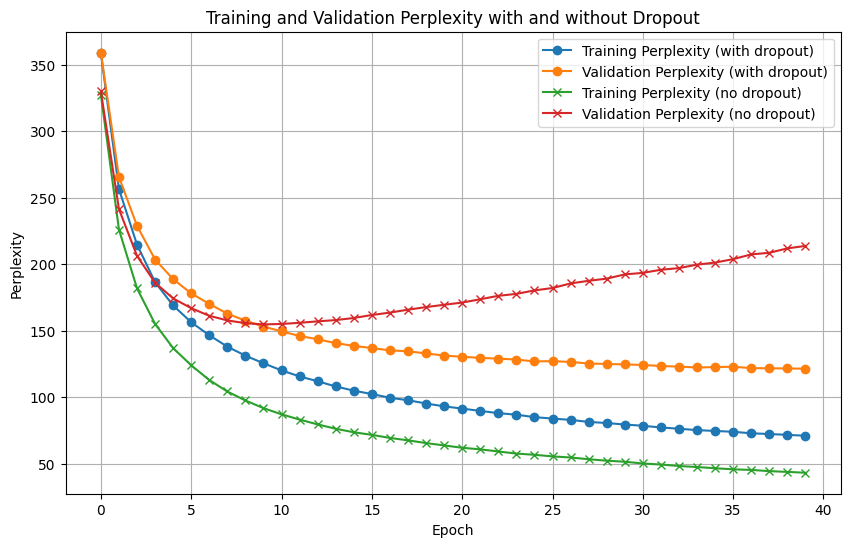

In [ ]:
# prompt: plot both on same plot

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, learning_rate, dropout, loss_or_preplexity = "Loss", model_type = "LSTM"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training ' + loss_or_preplexity, marker='o')
    plt.plot(val_losses, label='Validation ' + loss_or_preplexity, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel(loss_or_preplexity)
    plt.title(f'{model_type}: Epoch-Level {loss_or_preplexity}, Learning Rate: {learning_rate}, Dropout: {dropout}')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming you have the data from the two runs
# # Replace with your actual variable names
# plot_losses(per_epoch_train_losses, per_epoch_valid_losses, learning_rate=learning_rate, dropout=dropout_p)
# plot_losses(no_dropout[0], no_dropout[1], learning_rate=learning_rate, dropout=0)

# # If you want them in a single plot:
# plt.figure(figsize=(10, 6))
# plt.plot(per_epoch_train_losses, label='Training Loss (with dropout)', marker='o')
# plt.plot(per_epoch_valid_losses, label='Validation Loss (with dropout)', marker='o')
# plt.plot(no_dropout[0], label='Training Loss (no dropout)', marker='x')
# plt.plot(no_dropout[1], label='Validation Loss (no dropout)', marker='x')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss with and without Dropout')
# plt.legend()
# plt.grid()
# plt.show()

# Similarly, for perplexity:
plt.figure(figsize=(10, 6))
plt.plot(per_epoch_train_perplexities, label='Training Perplexity (with dropout)', marker='o')
plt.plot(per_epoch_valid_perplexities, label='Validation Perplexity (with dropout)', marker='o')
plt.plot(no_dropout[2], label='Training Perplexity (no dropout)', marker='x')
plt.plot(no_dropout[3], label='Validation Perplexity (no dropout)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity with and without Dropout')
plt.legend()
plt.grid()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout_p = 0
model_name = "GRU_no_dropout"
gru = hw2LSTM(batch_size,seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p,device,rnn_type = "GRU")
Gru_no_dropout = train(model= gru, train_x= encoded_train,train_y=train_labels,val_x = encoded_valid, val_y = valid_labels,batch_size= batch_size,learning_rate= learning_rate, n_epoches= n_epoches, clip= clip, validate_and_print_every= print_every,model_name=model_name)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40... Step: 300... Loss: 6.0194... Last train batch Perplexity: 411.3298...
Epoch: 1/40... Step: 600... Loss: 5.8758... Last train batch Perplexity: 356.3141...
Epoch: 1/40... Step: 900... Loss: 5.6922... Last train batch Perplexity: 296.5342...
Epoch: 1/40... Step: 1200... Loss: 4.9673... Last train batch Perplexity: 143.6346...


  2%|▎         | 1/40 [00:13<08:43, 13.42s/it]

Epoch: 01, Train Loss: 5.436, Valid Loss: 5.491, Train Perplexity: 233.611, Valid Perplexity: 245.840
Epoch: 2/40... Step: 1500... Loss: 5.3078... Last train batch Perplexity: 201.8994...
Epoch: 2/40... Step: 1800... Loss: 5.2421... Last train batch Perplexity: 189.0585...
Epoch: 2/40... Step: 2100... Loss: 5.0327... Last train batch Perplexity: 153.3426...
Epoch: 2/40... Step: 2400... Loss: 4.9165... Last train batch Perplexity: 136.5234...


  5%|▌         | 2/40 [00:27<08:39, 13.67s/it]

Epoch: 02, Train Loss: 5.091, Valid Loss: 5.244, Train Perplexity: 166.019, Valid Perplexity: 192.406
Epoch: 3/40... Step: 2700... Loss: 5.0607... Last train batch Perplexity: 157.6991...
Epoch: 3/40... Step: 3000... Loss: 5.2218... Last train batch Perplexity: 185.2760...
Epoch: 3/40... Step: 3300... Loss: 5.0390... Last train batch Perplexity: 154.3213...
Epoch: 3/40... Step: 3600... Loss: 4.9517... Last train batch Perplexity: 141.4169...
Epoch: 3/40... Step: 3900... Loss: 5.0919... Last train batch Perplexity: 162.7033...


  8%|▊         | 3/40 [00:40<08:21, 13.55s/it]

Epoch: 03, Train Loss: 4.884, Valid Loss: 5.124, Train Perplexity: 135.155, Valid Perplexity: 170.809
Epoch: 4/40... Step: 4200... Loss: 4.7851... Last train batch Perplexity: 119.7115...
Epoch: 4/40... Step: 4500... Loss: 4.8477... Last train batch Perplexity: 127.4503...
Epoch: 4/40... Step: 4800... Loss: 4.6735... Last train batch Perplexity: 107.0701...
Epoch: 4/40... Step: 5100... Loss: 5.0130... Last train batch Perplexity: 150.3601...


 10%|█         | 4/40 [00:53<07:59, 13.33s/it]

Epoch: 04, Train Loss: 4.731, Valid Loss: 5.050, Train Perplexity: 116.173, Valid Perplexity: 158.872
Epoch: 5/40... Step: 5400... Loss: 4.5566... Last train batch Perplexity: 95.2571...
Epoch: 5/40... Step: 5700... Loss: 4.7899... Last train batch Perplexity: 120.2852...
Epoch: 5/40... Step: 6000... Loss: 4.5921... Last train batch Perplexity: 98.7052...
Epoch: 5/40... Step: 6300... Loss: 4.3551... Last train batch Perplexity: 77.8760...
Epoch: 5/40... Step: 6600... Loss: 4.7458... Last train batch Perplexity: 115.1016...


 12%|█▎        | 5/40 [01:06<07:41, 13.18s/it]

Epoch: 05, Train Loss: 4.611, Valid Loss: 5.006, Train Perplexity: 103.151, Valid Perplexity: 152.177
Epoch: 6/40... Step: 6900... Loss: 4.7591... Last train batch Perplexity: 116.6412...
Epoch: 6/40... Step: 7200... Loss: 4.2240... Last train batch Perplexity: 68.3041...
Epoch: 6/40... Step: 7500... Loss: 4.8489... Last train batch Perplexity: 127.6030...
Epoch: 6/40... Step: 7800... Loss: 4.5843... Last train batch Perplexity: 97.9330...


 15%|█▌        | 6/40 [01:19<07:24, 13.08s/it]

Epoch: 06, Train Loss: 4.510, Valid Loss: 4.979, Train Perplexity: 93.373, Valid Perplexity: 148.357
Epoch: 7/40... Step: 8100... Loss: 4.6648... Last train batch Perplexity: 106.1419...
Epoch: 7/40... Step: 8400... Loss: 4.4468... Last train batch Perplexity: 85.3527...
Epoch: 7/40... Step: 8700... Loss: 4.2453... Last train batch Perplexity: 69.7732...
Epoch: 7/40... Step: 9000... Loss: 4.3419... Last train batch Perplexity: 76.8508...


 18%|█▊        | 7/40 [01:32<07:10, 13.04s/it]

Epoch: 07, Train Loss: 4.426, Valid Loss: 4.969, Train Perplexity: 85.970, Valid Perplexity: 146.932
Epoch: 8/40... Step: 9300... Loss: 4.5680... Last train batch Perplexity: 96.3549...
Epoch: 8/40... Step: 9600... Loss: 4.1640... Last train batch Perplexity: 64.3267...
Epoch: 8/40... Step: 9900... Loss: 4.5112... Last train batch Perplexity: 91.0346...
Epoch: 8/40... Step: 10200... Loss: 4.6399... Last train batch Perplexity: 103.5292...
Epoch: 8/40... Step: 10500... Loss: 4.1868... Last train batch Perplexity: 65.8125...


 20%|██        | 8/40 [01:45<06:55, 12.99s/it]

Epoch: 08, Train Loss: 4.356, Valid Loss: 4.970, Train Perplexity: 80.248, Valid Perplexity: 147.292
Epoch: 9/40... Step: 10800... Loss: 4.5037... Last train batch Perplexity: 90.3541...
Epoch: 9/40... Step: 11100... Loss: 4.2149... Last train batch Perplexity: 67.6869...
Epoch: 9/40... Step: 11400... Loss: 4.3358... Last train batch Perplexity: 76.3826...
Epoch: 9/40... Step: 11700... Loss: 4.0294... Last train batch Perplexity: 56.2275...


 22%|██▎       | 9/40 [01:58<06:41, 12.96s/it]

Epoch: 09, Train Loss: 4.296, Valid Loss: 4.980, Train Perplexity: 75.640, Valid Perplexity: 148.787
Epoch: 10/40... Step: 12000... Loss: 4.2170... Last train batch Perplexity: 67.8298...
Epoch: 10/40... Step: 12300... Loss: 4.0665... Last train batch Perplexity: 58.3542...
Epoch: 10/40... Step: 12600... Loss: 4.4412... Last train batch Perplexity: 84.8750...
Epoch: 10/40... Step: 12900... Loss: 4.6269... Last train batch Perplexity: 102.1974...
Epoch: 10/40... Step: 13200... Loss: 4.1438... Last train batch Perplexity: 63.0392...


 25%|██▌       | 10/40 [02:12<06:40, 13.36s/it]

Epoch: 10, Train Loss: 4.243, Valid Loss: 4.993, Train Perplexity: 71.780, Valid Perplexity: 150.848
Epoch: 11/40... Step: 13500... Loss: 4.4067... Last train batch Perplexity: 82.0004...
Epoch: 11/40... Step: 13800... Loss: 4.2575... Last train batch Perplexity: 70.6305...
Epoch: 11/40... Step: 14100... Loss: 3.9947... Last train batch Perplexity: 54.3114...
Epoch: 11/40... Step: 14400... Loss: 4.0760... Last train batch Perplexity: 58.9069...


 28%|██▊       | 11/40 [02:26<06:30, 13.46s/it]

Epoch: 11, Train Loss: 4.195, Valid Loss: 5.009, Train Perplexity: 68.504, Valid Perplexity: 153.369
Epoch: 12/40... Step: 14700... Loss: 3.9818... Last train batch Perplexity: 53.6111...
Epoch: 12/40... Step: 15000... Loss: 3.9465... Last train batch Perplexity: 51.7530...
Epoch: 12/40... Step: 15300... Loss: 4.3642... Last train batch Perplexity: 78.5833...
Epoch: 12/40... Step: 15600... Loss: 4.3851... Last train batch Perplexity: 80.2485...
Epoch: 12/40... Step: 15900... Loss: 4.2430... Last train batch Perplexity: 69.6151...


 30%|███       | 12/40 [02:38<06:11, 13.26s/it]

Epoch: 12, Train Loss: 4.154, Valid Loss: 5.026, Train Perplexity: 65.818, Valid Perplexity: 156.108
Epoch: 13/40... Step: 16200... Loss: 4.1460... Last train batch Perplexity: 63.1831...
Epoch: 13/40... Step: 16500... Loss: 4.0429... Last train batch Perplexity: 56.9903...
Epoch: 13/40... Step: 16800... Loss: 4.1055... Last train batch Perplexity: 60.6740...
Epoch: 13/40... Step: 17100... Loss: 4.2559... Last train batch Perplexity: 70.5218...


 32%|███▎      | 13/40 [02:51<05:54, 13.11s/it]

Epoch: 13, Train Loss: 4.117, Valid Loss: 5.043, Train Perplexity: 63.421, Valid Perplexity: 158.822
Epoch: 14/40... Step: 17400... Loss: 4.3237... Last train batch Perplexity: 75.4652...
Epoch: 14/40... Step: 17700... Loss: 4.2651... Last train batch Perplexity: 71.1706...
Epoch: 14/40... Step: 18000... Loss: 3.8536... Last train batch Perplexity: 47.1643...
Epoch: 14/40... Step: 18300... Loss: 3.9256... Last train batch Perplexity: 50.6858...


 35%|███▌      | 14/40 [03:04<05:38, 13.02s/it]

Epoch: 14, Train Loss: 4.084, Valid Loss: 5.058, Train Perplexity: 61.448, Valid Perplexity: 161.242
Epoch: 15/40... Step: 18600... Loss: 4.1735... Last train batch Perplexity: 64.9448...
Epoch: 15/40... Step: 18900... Loss: 3.9871... Last train batch Perplexity: 53.9003...
Epoch: 15/40... Step: 19200... Loss: 4.0668... Last train batch Perplexity: 58.3721...
Epoch: 15/40... Step: 19500... Loss: 3.9519... Last train batch Perplexity: 52.0344...
Epoch: 15/40... Step: 19800... Loss: 3.8131... Last train batch Perplexity: 45.2890...


 38%|███▊      | 15/40 [03:17<05:23, 12.96s/it]

Epoch: 15, Train Loss: 4.055, Valid Loss: 5.079, Train Perplexity: 59.728, Valid Perplexity: 164.815
Epoch: 16/40... Step: 20100... Loss: 4.2698... Last train batch Perplexity: 71.5095...
Epoch: 16/40... Step: 20400... Loss: 4.3164... Last train batch Perplexity: 74.9215...
Epoch: 16/40... Step: 20700... Loss: 4.0792... Last train batch Perplexity: 59.0965...
Epoch: 16/40... Step: 21000... Loss: 3.6096... Last train batch Perplexity: 36.9518...


 40%|████      | 16/40 [03:30<05:09, 12.90s/it]

Epoch: 16, Train Loss: 4.027, Valid Loss: 5.090, Train Perplexity: 58.083, Valid Perplexity: 166.594
Epoch: 17/40... Step: 21300... Loss: 4.0723... Last train batch Perplexity: 58.6924...
Epoch: 17/40... Step: 21600... Loss: 3.7050... Last train batch Perplexity: 40.6519...
Epoch: 17/40... Step: 21900... Loss: 3.5450... Last train batch Perplexity: 34.6398...
Epoch: 17/40... Step: 22200... Loss: 4.1822... Last train batch Perplexity: 65.5121...
Epoch: 17/40... Step: 22500... Loss: 3.6526... Last train batch Perplexity: 38.5739...


 42%|████▎     | 17/40 [03:42<04:56, 12.87s/it]

Epoch: 17, Train Loss: 3.998, Valid Loss: 5.108, Train Perplexity: 56.423, Valid Perplexity: 169.594
Epoch: 18/40... Step: 22800... Loss: 3.9257... Last train batch Perplexity: 50.6898...
Epoch: 18/40... Step: 23100... Loss: 4.3209... Last train batch Perplexity: 75.2595...
Epoch: 18/40... Step: 23400... Loss: 4.1806... Last train batch Perplexity: 65.4060...
Epoch: 18/40... Step: 23700... Loss: 4.0738... Last train batch Perplexity: 58.7785...


 45%|████▌     | 18/40 [03:55<04:42, 12.85s/it]

Epoch: 18, Train Loss: 3.973, Valid Loss: 5.120, Train Perplexity: 55.052, Valid Perplexity: 171.810
Epoch: 19/40... Step: 24000... Loss: 3.8736... Last train batch Perplexity: 48.1130...
Epoch: 19/40... Step: 24300... Loss: 4.0453... Last train batch Perplexity: 57.1283...
Epoch: 19/40... Step: 24600... Loss: 4.0133... Last train batch Perplexity: 55.3288...
Epoch: 19/40... Step: 24900... Loss: 4.2616... Last train batch Perplexity: 70.9260...
Epoch: 19/40... Step: 25200... Loss: 4.1398... Last train batch Perplexity: 62.7895...


 48%|████▊     | 19/40 [04:08<04:30, 12.89s/it]

Epoch: 19, Train Loss: 3.950, Valid Loss: 5.133, Train Perplexity: 53.793, Valid Perplexity: 174.145
Epoch: 20/40... Step: 25500... Loss: 3.8847... Last train batch Perplexity: 48.6512...
Epoch: 20/40... Step: 25800... Loss: 4.0158... Last train batch Perplexity: 55.4702...
Epoch: 20/40... Step: 26100... Loss: 3.8971... Last train batch Perplexity: 49.2594...
Epoch: 20/40... Step: 26400... Loss: 3.8661... Last train batch Perplexity: 47.7572...


 50%|█████     | 20/40 [04:21<04:17, 12.86s/it]

Epoch: 20, Train Loss: 3.925, Valid Loss: 5.141, Train Perplexity: 52.494, Valid Perplexity: 175.792
Epoch: 21/40... Step: 26700... Loss: 4.1293... Last train batch Perplexity: 62.1341...
Epoch: 21/40... Step: 27000... Loss: 3.7639... Last train batch Perplexity: 43.1148...
Epoch: 21/40... Step: 27300... Loss: 3.2231... Last train batch Perplexity: 25.1064...
Epoch: 21/40... Step: 27600... Loss: 3.6908... Last train batch Perplexity: 40.0762...


 52%|█████▎    | 21/40 [04:34<04:04, 12.85s/it]

Epoch: 21, Train Loss: 3.900, Valid Loss: 5.147, Train Perplexity: 51.163, Valid Perplexity: 176.700
Epoch: 22/40... Step: 27900... Loss: 3.7601... Last train batch Perplexity: 42.9524...
Epoch: 22/40... Step: 28200... Loss: 4.0373... Last train batch Perplexity: 56.6744...
Epoch: 22/40... Step: 28500... Loss: 4.0857... Last train batch Perplexity: 59.4830...
Epoch: 22/40... Step: 28800... Loss: 4.1333... Last train batch Perplexity: 62.3812...
Epoch: 22/40... Step: 29100... Loss: 3.8586... Last train batch Perplexity: 47.3983...


 55%|█████▌    | 22/40 [04:47<03:51, 12.84s/it]

Epoch: 22, Train Loss: 3.884, Valid Loss: 5.163, Train Perplexity: 50.378, Valid Perplexity: 179.548
Epoch: 23/40... Step: 29400... Loss: 3.9561... Last train batch Perplexity: 52.2545...
Epoch: 23/40... Step: 29700... Loss: 4.1230... Last train batch Perplexity: 61.7421...
Epoch: 23/40... Step: 30000... Loss: 3.8880... Last train batch Perplexity: 48.8140...
Epoch: 23/40... Step: 30300... Loss: 3.9520... Last train batch Perplexity: 52.0411...


 57%|█████▊    | 23/40 [04:59<03:38, 12.84s/it]

Epoch: 23, Train Loss: 3.864, Valid Loss: 5.172, Train Perplexity: 49.344, Valid Perplexity: 181.172
Epoch: 24/40... Step: 30600... Loss: 3.5362... Last train batch Perplexity: 34.3361...
Epoch: 24/40... Step: 30900... Loss: 3.6892... Last train batch Perplexity: 40.0128...
Epoch: 24/40... Step: 31200... Loss: 3.9610... Last train batch Perplexity: 52.5088...
Epoch: 24/40... Step: 31500... Loss: 4.2264... Last train batch Perplexity: 68.4699...
Epoch: 24/40... Step: 31800... Loss: 3.7338... Last train batch Perplexity: 41.8380...


 60%|██████    | 24/40 [05:12<03:25, 12.84s/it]

Epoch: 24, Train Loss: 3.846, Valid Loss: 5.185, Train Perplexity: 48.494, Valid Perplexity: 183.567
Epoch: 25/40... Step: 32100... Loss: 3.7869... Last train batch Perplexity: 44.1175...
Epoch: 25/40... Step: 32400... Loss: 4.0331... Last train batch Perplexity: 56.4350...
Epoch: 25/40... Step: 32700... Loss: 3.6928... Last train batch Perplexity: 40.1581...
Epoch: 25/40... Step: 33000... Loss: 3.6975... Last train batch Perplexity: 40.3462...


 62%|██████▎   | 25/40 [05:25<03:12, 12.83s/it]

Epoch: 25, Train Loss: 3.821, Valid Loss: 5.191, Train Perplexity: 47.286, Valid Perplexity: 184.865
Epoch: 26/40... Step: 33300... Loss: 3.7000... Last train batch Perplexity: 40.4483...
Epoch: 26/40... Step: 33600... Loss: 3.8545... Last train batch Perplexity: 47.2067...
Epoch: 26/40... Step: 33900... Loss: 3.6553... Last train batch Perplexity: 38.6808...
Epoch: 26/40... Step: 34200... Loss: 3.5155... Last train batch Perplexity: 33.6312...
Epoch: 26/40... Step: 34500... Loss: 4.1325... Last train batch Perplexity: 62.3361...


 65%|██████▌   | 26/40 [05:38<03:01, 12.93s/it]

Epoch: 26, Train Loss: 3.804, Valid Loss: 5.200, Train Perplexity: 46.450, Valid Perplexity: 186.550
Epoch: 27/40... Step: 34800... Loss: 3.5151... Last train batch Perplexity: 33.6188...
Epoch: 27/40... Step: 35100... Loss: 4.0113... Last train batch Perplexity: 55.2168...
Epoch: 27/40... Step: 35400... Loss: 3.9286... Last train batch Perplexity: 50.8355...
Epoch: 27/40... Step: 35700... Loss: 3.3860... Last train batch Perplexity: 29.5471...


 68%|██████▊   | 27/40 [05:51<02:47, 12.90s/it]

Epoch: 27, Train Loss: 3.793, Valid Loss: 5.215, Train Perplexity: 45.965, Valid Perplexity: 189.432
Epoch: 28/40... Step: 36000... Loss: 4.0614... Last train batch Perplexity: 58.0540...
Epoch: 28/40... Step: 36300... Loss: 3.8662... Last train batch Perplexity: 47.7611...
Epoch: 28/40... Step: 36600... Loss: 3.6649... Last train batch Perplexity: 39.0541...
Epoch: 28/40... Step: 36900... Loss: 3.3264... Last train batch Perplexity: 27.8383...


 70%|███████   | 28/40 [06:04<02:34, 12.88s/it]

Epoch: 28, Train Loss: 3.779, Valid Loss: 5.226, Train Perplexity: 45.330, Valid Perplexity: 191.434
Epoch: 29/40... Step: 37200... Loss: 3.8443... Last train batch Perplexity: 46.7253...
Epoch: 29/40... Step: 37500... Loss: 3.7191... Last train batch Perplexity: 41.2273...
Epoch: 29/40... Step: 37800... Loss: 3.7072... Last train batch Perplexity: 40.7408...
Epoch: 29/40... Step: 38100... Loss: 4.0204... Last train batch Perplexity: 55.7261...
Epoch: 29/40... Step: 38400... Loss: 3.9325... Last train batch Perplexity: 51.0344...


 72%|███████▎  | 29/40 [06:17<02:21, 12.87s/it]

Epoch: 29, Train Loss: 3.758, Valid Loss: 5.233, Train Perplexity: 44.353, Valid Perplexity: 192.701
Epoch: 30/40... Step: 38700... Loss: 3.7814... Last train batch Perplexity: 43.8783...
Epoch: 30/40... Step: 39000... Loss: 3.7085... Last train batch Perplexity: 40.7920...
Epoch: 30/40... Step: 39300... Loss: 3.8483... Last train batch Perplexity: 46.9154...
Epoch: 30/40... Step: 39600... Loss: 3.8358... Last train batch Perplexity: 46.3286...


 75%|███████▌  | 30/40 [06:30<02:08, 12.86s/it]

Epoch: 30, Train Loss: 3.743, Valid Loss: 5.242, Train Perplexity: 43.681, Valid Perplexity: 194.416
Epoch: 31/40... Step: 39900... Loss: 3.4317... Last train batch Perplexity: 30.9279...
Epoch: 31/40... Step: 40200... Loss: 3.7429... Last train batch Perplexity: 42.2204...
Epoch: 31/40... Step: 40500... Loss: 3.9003... Last train batch Perplexity: 49.4189...
Epoch: 31/40... Step: 40800... Loss: 3.9380... Last train batch Perplexity: 51.3155...
Epoch: 31/40... Step: 41100... Loss: 3.8669... Last train batch Perplexity: 47.7962...


 78%|███████▊  | 31/40 [06:42<01:55, 12.86s/it]

Epoch: 31, Train Loss: 3.731, Valid Loss: 5.246, Train Perplexity: 43.178, Valid Perplexity: 195.415
Epoch: 32/40... Step: 41400... Loss: 3.8976... Last train batch Perplexity: 49.2864...
Epoch: 32/40... Step: 41700... Loss: 3.6271... Last train batch Perplexity: 37.6026...
Epoch: 32/40... Step: 42000... Loss: 3.8235... Last train batch Perplexity: 45.7643...
Epoch: 32/40... Step: 42300... Loss: 3.7495... Last train batch Perplexity: 42.4980...


 80%|████████  | 32/40 [06:55<01:42, 12.85s/it]

Epoch: 32, Train Loss: 3.712, Valid Loss: 5.252, Train Perplexity: 42.340, Valid Perplexity: 196.794
Epoch: 33/40... Step: 42600... Loss: 3.8390... Last train batch Perplexity: 46.4794...
Epoch: 33/40... Step: 42900... Loss: 3.7867... Last train batch Perplexity: 44.1109...
Epoch: 33/40... Step: 43200... Loss: 3.5440... Last train batch Perplexity: 34.6058...
Epoch: 33/40... Step: 43500... Loss: 3.1519... Last train batch Perplexity: 23.3814...


 82%|████████▎ | 33/40 [07:08<01:29, 12.85s/it]

Epoch: 33, Train Loss: 3.698, Valid Loss: 5.264, Train Perplexity: 41.751, Valid Perplexity: 198.965
Epoch: 34/40... Step: 43800... Loss: 3.7515... Last train batch Perplexity: 42.5843...
Epoch: 34/40... Step: 44100... Loss: 3.4387... Last train batch Perplexity: 31.1451...
Epoch: 34/40... Step: 44400... Loss: 3.6952... Last train batch Perplexity: 40.2541...
Epoch: 34/40... Step: 44700... Loss: 3.5826... Last train batch Perplexity: 35.9680...
Epoch: 34/40... Step: 45000... Loss: 3.0386... Last train batch Perplexity: 20.8753...


 85%|████████▌ | 34/40 [07:21<01:17, 12.84s/it]

Epoch: 34, Train Loss: 3.682, Valid Loss: 5.262, Train Perplexity: 41.095, Valid Perplexity: 198.458
Epoch: 35/40... Step: 45300... Loss: 3.8829... Last train batch Perplexity: 48.5626...
Epoch: 35/40... Step: 45600... Loss: 3.5089... Last train batch Perplexity: 33.4125...
Epoch: 35/40... Step: 45900... Loss: 3.4477... Last train batch Perplexity: 31.4285...
Epoch: 35/40... Step: 46200... Loss: 3.3098... Last train batch Perplexity: 27.3807...


 88%|████████▊ | 35/40 [07:34<01:04, 12.84s/it]

Epoch: 35, Train Loss: 3.673, Valid Loss: 5.272, Train Perplexity: 40.695, Valid Perplexity: 200.458
Epoch: 36/40... Step: 46500... Loss: 3.7645... Last train batch Perplexity: 43.1439...
Epoch: 36/40... Step: 46800... Loss: 3.6407... Last train batch Perplexity: 38.1203...
Epoch: 36/40... Step: 47100... Loss: 3.6981... Last train batch Perplexity: 40.3704...
Epoch: 36/40... Step: 47400... Loss: 3.8516... Last train batch Perplexity: 47.0705...
Epoch: 36/40... Step: 47700... Loss: 3.5385... Last train batch Perplexity: 34.4142...


 90%|█████████ | 36/40 [07:47<00:51, 12.84s/it]

Epoch: 36, Train Loss: 3.657, Valid Loss: 5.281, Train Perplexity: 40.040, Valid Perplexity: 202.300
Epoch: 37/40... Step: 48000... Loss: 3.7734... Last train batch Perplexity: 43.5288...
Epoch: 37/40... Step: 48300... Loss: 3.6099... Last train batch Perplexity: 36.9612...
Epoch: 37/40... Step: 48600... Loss: 3.5360... Last train batch Perplexity: 34.3303...
Epoch: 37/40... Step: 48900... Loss: 3.7318... Last train batch Perplexity: 41.7527...


 92%|█████████▎| 37/40 [08:00<00:38, 12.85s/it]

Epoch: 37, Train Loss: 3.647, Valid Loss: 5.286, Train Perplexity: 39.636, Valid Perplexity: 203.532
Epoch: 38/40... Step: 49200... Loss: 3.4273... Last train batch Perplexity: 30.7939...
Epoch: 38/40... Step: 49500... Loss: 3.5566... Last train batch Perplexity: 35.0427...
Epoch: 38/40... Step: 49800... Loss: 3.7845... Last train batch Perplexity: 44.0132...
Epoch: 38/40... Step: 50100... Loss: 3.8061... Last train batch Perplexity: 44.9756...
Epoch: 38/40... Step: 50400... Loss: 3.7825... Last train batch Perplexity: 43.9241...


 95%|█████████▌| 38/40 [08:12<00:25, 12.85s/it]

Epoch: 38, Train Loss: 3.636, Valid Loss: 5.297, Train Perplexity: 39.208, Valid Perplexity: 205.815
Epoch: 39/40... Step: 50700... Loss: 3.8353... Last train batch Perplexity: 46.3068...
Epoch: 39/40... Step: 51000... Loss: 3.3368... Last train batch Perplexity: 28.1281...
Epoch: 39/40... Step: 51300... Loss: 3.5792... Last train batch Perplexity: 35.8455...
Epoch: 39/40... Step: 51600... Loss: 3.5854... Last train batch Perplexity: 36.0689...


 98%|█████████▊| 39/40 [08:25<00:12, 12.86s/it]

Epoch: 39, Train Loss: 3.625, Valid Loss: 5.299, Train Perplexity: 38.766, Valid Perplexity: 206.295
Epoch: 40/40... Step: 51900... Loss: 3.8023... Last train batch Perplexity: 44.8057...
Epoch: 40/40... Step: 52200... Loss: 3.5085... Last train batch Perplexity: 33.3992...
Epoch: 40/40... Step: 52500... Loss: 3.4001... Last train batch Perplexity: 29.9663...
Epoch: 40/40... Step: 52800... Loss: 3.3680... Last train batch Perplexity: 29.0207...


100%|██████████| 40/40 [08:38<00:00, 12.97s/it]

Epoch: 40, Train Loss: 3.618, Valid Loss: 5.311, Train Perplexity: 38.488, Valid Perplexity: 208.748


In [ ]:
dropout_p = 0.3
model_name = "GRU_dropout_0.3"
gru = hw2LSTM(batch_size,seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p,device,rnn_type = "GRU")
Gru_dropout = train(model= gru, train_x= encoded_train,train_y=train_labels,val_x = encoded_valid, val_y = valid_labels,batch_size= batch_size,learning_rate= learning_rate, n_epoches= n_epoches, clip= clip, validate_and_print_every= print_every,model_name=model_name)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40... Step: 300... Loss: 6.0733... Last train batch Perplexity: 434.0897...
Epoch: 1/40... Step: 600... Loss: 6.0196... Last train batch Perplexity: 411.4277...
Epoch: 1/40... Step: 900... Loss: 5.8355... Last train batch Perplexity: 342.2413...
Epoch: 1/40... Step: 1200... Loss: 5.1497... Last train batch Perplexity: 172.3790...


  2%|▎         | 1/40 [00:13<08:39, 13.33s/it]

Epoch: 01, Train Loss: 5.562, Valid Loss: 5.593, Train Perplexity: 264.844, Valid Perplexity: 272.497
Epoch: 2/40... Step: 1500... Loss: 5.4991... Last train batch Perplexity: 244.4685...
Epoch: 2/40... Step: 1800... Loss: 5.4097... Last train batch Perplexity: 223.5614...
Epoch: 2/40... Step: 2100... Loss: 5.3045... Last train batch Perplexity: 201.2410...
Epoch: 2/40... Step: 2400... Loss: 5.1741... Last train batch Perplexity: 176.6441...


  5%|▌         | 2/40 [00:26<08:26, 13.34s/it]

Epoch: 02, Train Loss: 5.274, Valid Loss: 5.358, Train Perplexity: 198.780, Valid Perplexity: 215.651
Epoch: 3/40... Step: 2700... Loss: 5.3369... Last train batch Perplexity: 207.8578...
Epoch: 3/40... Step: 3000... Loss: 5.5062... Last train batch Perplexity: 246.2234...
Epoch: 3/40... Step: 3300... Loss: 5.3533... Last train batch Perplexity: 211.3106...
Epoch: 3/40... Step: 3600... Loss: 5.3003... Last train batch Perplexity: 200.3891...
Epoch: 3/40... Step: 3900... Loss: 5.4262... Last train batch Perplexity: 227.2791...


  8%|▊         | 3/40 [00:39<08:12, 13.31s/it]

Epoch: 03, Train Loss: 5.119, Valid Loss: 5.246, Train Perplexity: 170.448, Valid Perplexity: 192.872
Epoch: 4/40... Step: 4200... Loss: 5.1300... Last train batch Perplexity: 169.0121...
Epoch: 4/40... Step: 4500... Loss: 5.1606... Last train batch Perplexity: 174.2762...
Epoch: 4/40... Step: 4800... Loss: 5.0782... Last train batch Perplexity: 160.4847...
Epoch: 4/40... Step: 5100... Loss: 5.3771... Last train batch Perplexity: 216.3974...


 10%|█         | 4/40 [00:53<07:57, 13.27s/it]

Epoch: 04, Train Loss: 4.998, Valid Loss: 5.161, Train Perplexity: 151.175, Valid Perplexity: 177.337
Epoch: 5/40... Step: 5400... Loss: 4.9637... Last train batch Perplexity: 143.1236...
Epoch: 5/40... Step: 5700... Loss: 5.2028... Last train batch Perplexity: 181.7895...
Epoch: 5/40... Step: 6000... Loss: 4.9236... Last train batch Perplexity: 137.4991...
Epoch: 5/40... Step: 6300... Loss: 4.7877... Last train batch Perplexity: 120.0192...
Epoch: 5/40... Step: 6600... Loss: 5.2334... Last train batch Perplexity: 187.4239...


 12%|█▎        | 5/40 [01:06<07:42, 13.22s/it]

Epoch: 05, Train Loss: 4.905, Valid Loss: 5.097, Train Perplexity: 137.759, Valid Perplexity: 166.326
Epoch: 6/40... Step: 6900... Loss: 5.2300... Last train batch Perplexity: 186.7943...
Epoch: 6/40... Step: 7200... Loss: 4.6480... Last train batch Perplexity: 104.3754...
Epoch: 6/40... Step: 7500... Loss: 5.3357... Last train batch Perplexity: 207.6202...
Epoch: 6/40... Step: 7800... Loss: 4.9791... Last train batch Perplexity: 145.3419...


 15%|█▌        | 6/40 [01:19<07:28, 13.18s/it]

Epoch: 06, Train Loss: 4.835, Valid Loss: 5.057, Train Perplexity: 128.563, Valid Perplexity: 159.891
Epoch: 7/40... Step: 8100... Loss: 5.0932... Last train batch Perplexity: 162.9152...
Epoch: 7/40... Step: 8400... Loss: 4.9575... Last train batch Perplexity: 142.2423...
Epoch: 7/40... Step: 8700... Loss: 4.7759... Last train batch Perplexity: 118.6179...
Epoch: 7/40... Step: 9000... Loss: 4.8127... Last train batch Perplexity: 123.0666...


 18%|█▊        | 7/40 [01:32<07:12, 13.12s/it]

Epoch: 07, Train Loss: 4.777, Valid Loss: 5.025, Train Perplexity: 121.363, Valid Perplexity: 155.005
Epoch: 8/40... Step: 9300... Loss: 5.0827... Last train batch Perplexity: 161.2058...
Epoch: 8/40... Step: 9600... Loss: 4.7067... Last train batch Perplexity: 110.6829...
Epoch: 8/40... Step: 9900... Loss: 5.0618... Last train batch Perplexity: 157.8692...
Epoch: 8/40... Step: 10200... Loss: 5.1988... Last train batch Perplexity: 181.0543...
Epoch: 8/40... Step: 10500... Loss: 4.7077... Last train batch Perplexity: 110.7983...


 20%|██        | 8/40 [01:45<06:58, 13.08s/it]

Epoch: 08, Train Loss: 4.723, Valid Loss: 4.998, Train Perplexity: 114.977, Valid Perplexity: 150.825
Epoch: 9/40... Step: 10800... Loss: 5.0348... Last train batch Perplexity: 153.6741...
Epoch: 9/40... Step: 11100... Loss: 4.7189... Last train batch Perplexity: 112.0494...
Epoch: 9/40... Step: 11400... Loss: 4.9688... Last train batch Perplexity: 143.8558...
Epoch: 9/40... Step: 11700... Loss: 4.5625... Last train batch Perplexity: 95.8198...


 22%|██▎       | 9/40 [01:58<06:44, 13.06s/it]

Epoch: 09, Train Loss: 4.675, Valid Loss: 4.972, Train Perplexity: 109.564, Valid Perplexity: 147.118
Epoch: 10/40... Step: 12000... Loss: 4.7917... Last train batch Perplexity: 120.5097...
Epoch: 10/40... Step: 12300... Loss: 4.7364... Last train batch Perplexity: 114.0193...
Epoch: 10/40... Step: 12600... Loss: 5.0748... Last train batch Perplexity: 159.9460...
Epoch: 10/40... Step: 12900... Loss: 5.2451... Last train batch Perplexity: 189.6438...
Epoch: 10/40... Step: 13200... Loss: 4.7420... Last train batch Perplexity: 114.6626...


 25%|██▌       | 10/40 [02:11<06:30, 13.03s/it]

Epoch: 10, Train Loss: 4.634, Valid Loss: 4.956, Train Perplexity: 105.228, Valid Perplexity: 144.709
Epoch: 11/40... Step: 13500... Loss: 5.0580... Last train batch Perplexity: 157.2760...
Epoch: 11/40... Step: 13800... Loss: 4.8734... Last train batch Perplexity: 130.7693...
Epoch: 11/40... Step: 14100... Loss: 4.5559... Last train batch Perplexity: 95.1893...
Epoch: 11/40... Step: 14400... Loss: 4.6045... Last train batch Perplexity: 99.9300...


 28%|██▊       | 11/40 [02:24<06:17, 13.03s/it]

Epoch: 11, Train Loss: 4.598, Valid Loss: 4.943, Train Perplexity: 101.526, Valid Perplexity: 142.920
Epoch: 12/40... Step: 14700... Loss: 4.6513... Last train batch Perplexity: 104.7221...
Epoch: 12/40... Step: 15000... Loss: 4.5040... Last train batch Perplexity: 90.3752...
Epoch: 12/40... Step: 15300... Loss: 4.9796... Last train batch Perplexity: 145.4198...
Epoch: 12/40... Step: 15600... Loss: 5.0764... Last train batch Perplexity: 160.1970...
Epoch: 12/40... Step: 15900... Loss: 4.9523... Last train batch Perplexity: 141.4956...


 30%|███       | 12/40 [02:37<06:04, 13.02s/it]

Epoch: 12, Train Loss: 4.564, Valid Loss: 4.926, Train Perplexity: 98.108, Valid Perplexity: 140.541
Epoch: 13/40... Step: 16200... Loss: 4.7983... Last train batch Perplexity: 121.3074...
Epoch: 13/40... Step: 16500... Loss: 4.7398... Last train batch Perplexity: 114.4161...
Epoch: 13/40... Step: 16800... Loss: 4.6755... Last train batch Perplexity: 107.2888...
Epoch: 13/40... Step: 17100... Loss: 4.9145... Last train batch Perplexity: 136.2529...


 32%|███▎      | 13/40 [02:50<05:51, 13.01s/it]

Epoch: 13, Train Loss: 4.536, Valid Loss: 4.916, Train Perplexity: 95.396, Valid Perplexity: 139.111
Epoch: 14/40... Step: 17400... Loss: 4.9812... Last train batch Perplexity: 145.6530...
Epoch: 14/40... Step: 17700... Loss: 5.0216... Last train batch Perplexity: 151.6466...
Epoch: 14/40... Step: 18000... Loss: 4.6598... Last train batch Perplexity: 105.6133...
Epoch: 14/40... Step: 18300... Loss: 4.6325... Last train batch Perplexity: 102.7679...


 35%|███▌      | 14/40 [03:03<05:37, 13.00s/it]

Epoch: 14, Train Loss: 4.508, Valid Loss: 4.909, Train Perplexity: 92.816, Valid Perplexity: 138.295
Epoch: 15/40... Step: 18600... Loss: 4.8846... Last train batch Perplexity: 132.2400...
Epoch: 15/40... Step: 18900... Loss: 4.6457... Last train batch Perplexity: 104.1316...
Epoch: 15/40... Step: 19200... Loss: 4.6671... Last train batch Perplexity: 106.3861...
Epoch: 15/40... Step: 19500... Loss: 4.6038... Last train batch Perplexity: 99.8621...
Epoch: 15/40... Step: 19800... Loss: 4.4414... Last train batch Perplexity: 84.8932...


 38%|███▊      | 15/40 [03:16<05:25, 13.00s/it]

Epoch: 15, Train Loss: 4.484, Valid Loss: 4.903, Train Perplexity: 90.616, Valid Perplexity: 137.488
Epoch: 16/40... Step: 20100... Loss: 4.9654... Last train batch Perplexity: 143.3643...
Epoch: 16/40... Step: 20400... Loss: 5.0601... Last train batch Perplexity: 157.6079...
Epoch: 16/40... Step: 20700... Loss: 4.7833... Last train batch Perplexity: 119.5015...
Epoch: 16/40... Step: 21000... Loss: 4.4375... Last train batch Perplexity: 84.5625...


 40%|████      | 16/40 [03:29<05:11, 13.00s/it]

Epoch: 16, Train Loss: 4.460, Valid Loss: 4.896, Train Perplexity: 88.439, Valid Perplexity: 136.466
Epoch: 17/40... Step: 21300... Loss: 4.7396... Last train batch Perplexity: 114.3853...
Epoch: 17/40... Step: 21600... Loss: 4.3556... Last train batch Perplexity: 77.9156...
Epoch: 17/40... Step: 21900... Loss: 4.1985... Last train batch Perplexity: 66.5881...
Epoch: 17/40... Step: 22200... Loss: 4.9327... Last train batch Perplexity: 138.7494...
Epoch: 17/40... Step: 22500... Loss: 4.3094... Last train batch Perplexity: 74.3967...


 42%|████▎     | 17/40 [03:42<04:58, 12.99s/it]

Epoch: 17, Train Loss: 4.440, Valid Loss: 4.891, Train Perplexity: 86.724, Valid Perplexity: 135.847
Epoch: 18/40... Step: 22800... Loss: 4.6242... Last train batch Perplexity: 101.9202...
Epoch: 18/40... Step: 23100... Loss: 5.0197... Last train batch Perplexity: 151.3712...
Epoch: 18/40... Step: 23400... Loss: 4.8571... Last train batch Perplexity: 128.6534...
Epoch: 18/40... Step: 23700... Loss: 4.9278... Last train batch Perplexity: 138.0690...


 45%|████▌     | 18/40 [03:55<04:45, 12.99s/it]

Epoch: 18, Train Loss: 4.419, Valid Loss: 4.885, Train Perplexity: 84.874, Valid Perplexity: 134.971
Epoch: 19/40... Step: 24000... Loss: 4.5870... Last train batch Perplexity: 98.1957...
Epoch: 19/40... Step: 24300... Loss: 4.7349... Last train batch Perplexity: 113.8548...
Epoch: 19/40... Step: 24600... Loss: 4.6870... Last train batch Perplexity: 108.5283...
Epoch: 19/40... Step: 24900... Loss: 4.9406... Last train batch Perplexity: 139.8535...
Epoch: 19/40... Step: 25200... Loss: 4.9006... Last train batch Perplexity: 134.3738...


 48%|████▊     | 19/40 [04:08<04:32, 13.00s/it]

Epoch: 19, Train Loss: 4.397, Valid Loss: 4.879, Train Perplexity: 83.085, Valid Perplexity: 134.260
Epoch: 20/40... Step: 25500... Loss: 4.5564... Last train batch Perplexity: 95.2368...
Epoch: 20/40... Step: 25800... Loss: 4.8305... Last train batch Perplexity: 125.2695...
Epoch: 20/40... Step: 26100... Loss: 4.6318... Last train batch Perplexity: 102.6981...
Epoch: 20/40... Step: 26400... Loss: 4.5409... Last train batch Perplexity: 93.7758...


 50%|█████     | 20/40 [04:21<04:19, 12.99s/it]

Epoch: 20, Train Loss: 4.381, Valid Loss: 4.877, Train Perplexity: 81.747, Valid Perplexity: 134.041
Epoch: 21/40... Step: 26700... Loss: 4.7968... Last train batch Perplexity: 121.1189...
Epoch: 21/40... Step: 27000... Loss: 4.4908... Last train batch Perplexity: 89.1892...
Epoch: 21/40... Step: 27300... Loss: 3.8180... Last train batch Perplexity: 45.5151...
Epoch: 21/40... Step: 27600... Loss: 4.4508... Last train batch Perplexity: 85.6918...


 52%|█████▎    | 21/40 [04:34<04:06, 12.99s/it]

Epoch: 21, Train Loss: 4.363, Valid Loss: 4.874, Train Perplexity: 80.265, Valid Perplexity: 133.755
Epoch: 22/40... Step: 27900... Loss: 4.5331... Last train batch Perplexity: 93.0441...
Epoch: 22/40... Step: 28200... Loss: 4.6013... Last train batch Perplexity: 99.6119...
Epoch: 22/40... Step: 28500... Loss: 4.7406... Last train batch Perplexity: 114.5041...
Epoch: 22/40... Step: 28800... Loss: 4.9231... Last train batch Perplexity: 137.4296...
Epoch: 22/40... Step: 29100... Loss: 4.6240... Last train batch Perplexity: 101.9051...


 55%|█████▌    | 22/40 [04:47<03:53, 12.99s/it]

Epoch: 22, Train Loss: 4.345, Valid Loss: 4.870, Train Perplexity: 78.849, Valid Perplexity: 133.172
Epoch: 23/40... Step: 29400... Loss: 4.7330... Last train batch Perplexity: 113.6370...
Epoch: 23/40... Step: 29700... Loss: 4.8753... Last train batch Perplexity: 131.0098...
Epoch: 23/40... Step: 30000... Loss: 4.5803... Last train batch Perplexity: 97.5449...
Epoch: 23/40... Step: 30300... Loss: 4.7813... Last train batch Perplexity: 119.2592...


 57%|█████▊    | 23/40 [05:00<03:40, 12.99s/it]

Epoch: 23, Train Loss: 4.330, Valid Loss: 4.869, Train Perplexity: 77.698, Valid Perplexity: 132.947
Epoch: 24/40... Step: 30600... Loss: 4.3959... Last train batch Perplexity: 81.1195...
Epoch: 24/40... Step: 30900... Loss: 4.4752... Last train batch Perplexity: 87.8153...
Epoch: 24/40... Step: 31200... Loss: 4.6030... Last train batch Perplexity: 99.7787...
Epoch: 24/40... Step: 31500... Loss: 4.8202... Last train batch Perplexity: 123.9876...
Epoch: 24/40... Step: 31800... Loss: 4.4824... Last train batch Perplexity: 88.4472...


 60%|██████    | 24/40 [05:13<03:27, 12.99s/it]

Epoch: 24, Train Loss: 4.317, Valid Loss: 4.868, Train Perplexity: 76.642, Valid Perplexity: 132.825
Epoch: 25/40... Step: 32100... Loss: 4.5263... Last train batch Perplexity: 92.4198...
Epoch: 25/40... Step: 32400... Loss: 4.9379... Last train batch Perplexity: 139.4723...
Epoch: 25/40... Step: 32700... Loss: 4.4039... Last train batch Perplexity: 81.7658...
Epoch: 25/40... Step: 33000... Loss: 4.3722... Last train batch Perplexity: 79.2163...


 62%|██████▎   | 25/40 [05:26<03:14, 12.99s/it]

Epoch: 25, Train Loss: 4.301, Valid Loss: 4.863, Train Perplexity: 75.436, Valid Perplexity: 132.316
Epoch: 26/40... Step: 33300... Loss: 4.3710... Last train batch Perplexity: 79.1203...
Epoch: 26/40... Step: 33600... Loss: 4.7182... Last train batch Perplexity: 111.9682...
Epoch: 26/40... Step: 33900... Loss: 4.3717... Last train batch Perplexity: 79.1745...
Epoch: 26/40... Step: 34200... Loss: 4.3261... Last train batch Perplexity: 75.6456...
Epoch: 26/40... Step: 34500... Loss: 4.9198... Last train batch Perplexity: 136.9758...


 65%|██████▌   | 26/40 [05:39<03:01, 12.97s/it]

Epoch: 26, Train Loss: 4.292, Valid Loss: 4.869, Train Perplexity: 74.734, Valid Perplexity: 133.106
Epoch: 27/40... Step: 34800... Loss: 4.3007... Last train batch Perplexity: 73.7526...
Epoch: 27/40... Step: 35100... Loss: 4.8216... Last train batch Perplexity: 124.1674...
Epoch: 27/40... Step: 35400... Loss: 4.6127... Last train batch Perplexity: 100.7548...
Epoch: 27/40... Step: 35700... Loss: 4.1509... Last train batch Perplexity: 63.4907...


 68%|██████▊   | 27/40 [05:52<02:48, 12.96s/it]

Epoch: 27, Train Loss: 4.279, Valid Loss: 4.868, Train Perplexity: 73.800, Valid Perplexity: 132.988
Epoch: 28/40... Step: 36000... Loss: 4.7643... Last train batch Perplexity: 117.2540...
Epoch: 28/40... Step: 36300... Loss: 4.6797... Last train batch Perplexity: 107.7356...
Epoch: 28/40... Step: 36600... Loss: 4.2992... Last train batch Perplexity: 73.6415...
Epoch: 28/40... Step: 36900... Loss: 4.0535... Last train batch Perplexity: 57.6001...


 70%|███████   | 28/40 [06:05<02:35, 12.96s/it]

Epoch: 28, Train Loss: 4.263, Valid Loss: 4.863, Train Perplexity: 72.658, Valid Perplexity: 132.382
Epoch: 29/40... Step: 37200... Loss: 4.6371... Last train batch Perplexity: 103.2450...
Epoch: 29/40... Step: 37500... Loss: 4.7276... Last train batch Perplexity: 113.0257...
Epoch: 29/40... Step: 37800... Loss: 4.2851... Last train batch Perplexity: 72.6072...
Epoch: 29/40... Step: 38100... Loss: 4.7787... Last train batch Perplexity: 118.9440...
Epoch: 29/40... Step: 38400... Loss: 4.5518... Last train batch Perplexity: 94.8071...


 72%|███████▎  | 29/40 [06:18<02:22, 12.98s/it]

Epoch: 29, Train Loss: 4.252, Valid Loss: 4.862, Train Perplexity: 71.838, Valid Perplexity: 132.302
Epoch: 30/40... Step: 38700... Loss: 4.4941... Last train batch Perplexity: 89.4870...
Epoch: 30/40... Step: 39000... Loss: 4.5239... Last train batch Perplexity: 92.1976...
Epoch: 30/40... Step: 39300... Loss: 4.5686... Last train batch Perplexity: 96.4077...
Epoch: 30/40... Step: 39600... Loss: 4.5552... Last train batch Perplexity: 95.1286...


 75%|███████▌  | 30/40 [06:31<02:09, 12.97s/it]

Epoch: 30, Train Loss: 4.243, Valid Loss: 4.865, Train Perplexity: 71.174, Valid Perplexity: 132.562
Epoch: 31/40... Step: 39900... Loss: 4.2308... Last train batch Perplexity: 68.7708...
Epoch: 31/40... Step: 40200... Loss: 4.6583... Last train batch Perplexity: 105.4532...
Epoch: 31/40... Step: 40500... Loss: 4.6397... Last train batch Perplexity: 103.5158...
Epoch: 31/40... Step: 40800... Loss: 4.7207... Last train batch Perplexity: 112.2474...
Epoch: 31/40... Step: 41100... Loss: 4.5774... Last train batch Perplexity: 97.2589...


 78%|███████▊  | 31/40 [06:44<01:56, 12.98s/it]

Epoch: 31, Train Loss: 4.231, Valid Loss: 4.863, Train Perplexity: 70.336, Valid Perplexity: 132.449
Epoch: 32/40... Step: 41400... Loss: 4.6845... Last train batch Perplexity: 108.2546...
Epoch: 32/40... Step: 41700... Loss: 4.5410... Last train batch Perplexity: 93.7846...
Epoch: 32/40... Step: 42000... Loss: 4.6422... Last train batch Perplexity: 103.7715...
Epoch: 32/40... Step: 42300... Loss: 4.5218... Last train batch Perplexity: 91.9966...


 80%|████████  | 32/40 [06:57<01:44, 13.01s/it]

Epoch: 32, Train Loss: 4.224, Valid Loss: 4.867, Train Perplexity: 69.802, Valid Perplexity: 132.954
Epoch: 33/40... Step: 42600... Loss: 4.6377... Last train batch Perplexity: 103.3053...
Epoch: 33/40... Step: 42900... Loss: 4.5402... Last train batch Perplexity: 93.7052...
Epoch: 33/40... Step: 43200... Loss: 4.3513... Last train batch Perplexity: 77.5830...
Epoch: 33/40... Step: 43500... Loss: 3.9200... Last train batch Perplexity: 50.4000...


 82%|████████▎ | 33/40 [07:10<01:31, 13.02s/it]

Epoch: 33, Train Loss: 4.212, Valid Loss: 4.868, Train Perplexity: 68.978, Valid Perplexity: 133.006
Epoch: 34/40... Step: 43800... Loss: 4.6519... Last train batch Perplexity: 104.7883...
Epoch: 34/40... Step: 44100... Loss: 4.1506... Last train batch Perplexity: 63.4689...
Epoch: 34/40... Step: 44400... Loss: 4.4994... Last train batch Perplexity: 89.9591...
Epoch: 34/40... Step: 44700... Loss: 4.3403... Last train batch Perplexity: 76.7275...
Epoch: 34/40... Step: 45000... Loss: 3.9597... Last train batch Perplexity: 52.4418...


 85%|████████▌ | 34/40 [07:23<01:18, 13.06s/it]

Epoch: 34, Train Loss: 4.202, Valid Loss: 4.867, Train Perplexity: 68.264, Valid Perplexity: 132.964
Epoch: 35/40... Step: 45300... Loss: 4.6490... Last train batch Perplexity: 104.4761...
Epoch: 35/40... Step: 45600... Loss: 4.1576... Last train batch Perplexity: 63.9195...
Epoch: 35/40... Step: 45900... Loss: 4.4160... Last train batch Perplexity: 82.7673...
Epoch: 35/40... Step: 46200... Loss: 4.2078... Last train batch Perplexity: 67.2095...


 88%|████████▊ | 35/40 [07:36<01:05, 13.11s/it]

Epoch: 35, Train Loss: 4.194, Valid Loss: 4.869, Train Perplexity: 67.785, Valid Perplexity: 133.242
Epoch: 36/40... Step: 46500... Loss: 4.5230... Last train batch Perplexity: 92.1117...
Epoch: 36/40... Step: 46800... Loss: 4.5592... Last train batch Perplexity: 95.5074...
Epoch: 36/40... Step: 47100... Loss: 4.5098... Last train batch Perplexity: 90.9002...
Epoch: 36/40... Step: 47400... Loss: 4.5792... Last train batch Perplexity: 97.4361...
Epoch: 36/40... Step: 47700... Loss: 4.4230... Last train batch Perplexity: 83.3457...


 90%|█████████ | 36/40 [07:49<00:52, 13.17s/it]

Epoch: 36, Train Loss: 4.184, Valid Loss: 4.865, Train Perplexity: 67.065, Valid Perplexity: 132.658
Epoch: 37/40... Step: 48000... Loss: 4.5836... Last train batch Perplexity: 97.8614...
Epoch: 37/40... Step: 48300... Loss: 4.4062... Last train batch Perplexity: 81.9610...
Epoch: 37/40... Step: 48600... Loss: 4.2195... Last train batch Perplexity: 67.9996...
Epoch: 37/40... Step: 48900... Loss: 4.5516... Last train batch Perplexity: 94.7870...


 92%|█████████▎| 37/40 [08:03<00:39, 13.19s/it]

Epoch: 37, Train Loss: 4.178, Valid Loss: 4.866, Train Perplexity: 66.652, Valid Perplexity: 132.807
Epoch: 38/40... Step: 49200... Loss: 4.1233... Last train batch Perplexity: 61.7650...
Epoch: 38/40... Step: 49500... Loss: 4.4542... Last train batch Perplexity: 85.9916...
Epoch: 38/40... Step: 49800... Loss: 4.5637... Last train batch Perplexity: 95.9389...
Epoch: 38/40... Step: 50100... Loss: 4.5112... Last train batch Perplexity: 91.0297...
Epoch: 38/40... Step: 50400... Loss: 4.6516... Last train batch Perplexity: 104.7530...


 95%|█████████▌| 38/40 [08:16<00:26, 13.20s/it]

Epoch: 38, Train Loss: 4.169, Valid Loss: 4.867, Train Perplexity: 66.094, Valid Perplexity: 133.010
Epoch: 39/40... Step: 50700... Loss: 4.7696... Last train batch Perplexity: 117.8707...
Epoch: 39/40... Step: 51000... Loss: 4.0865... Last train batch Perplexity: 59.5304...
Epoch: 39/40... Step: 51300... Loss: 4.3493... Last train batch Perplexity: 77.4243...
Epoch: 39/40... Step: 51600... Loss: 4.4018... Last train batch Perplexity: 81.5941...


 98%|█████████▊| 39/40 [08:29<00:13, 13.20s/it]

Epoch: 39, Train Loss: 4.160, Valid Loss: 4.865, Train Perplexity: 65.450, Valid Perplexity: 132.815
Epoch: 40/40... Step: 51900... Loss: 4.5716... Last train batch Perplexity: 96.7004...
Epoch: 40/40... Step: 52200... Loss: 4.2038... Last train batch Perplexity: 66.9398...
Epoch: 40/40... Step: 52500... Loss: 4.1099... Last train batch Perplexity: 60.9430...
Epoch: 40/40... Step: 52800... Loss: 4.2236... Last train batch Perplexity: 68.2791...


100%|██████████| 40/40 [08:42<00:00, 13.07s/it]

Epoch: 40, Train Loss: 4.151, Valid Loss: 4.866, Train Perplexity: 64.922, Valid Perplexity: 132.872


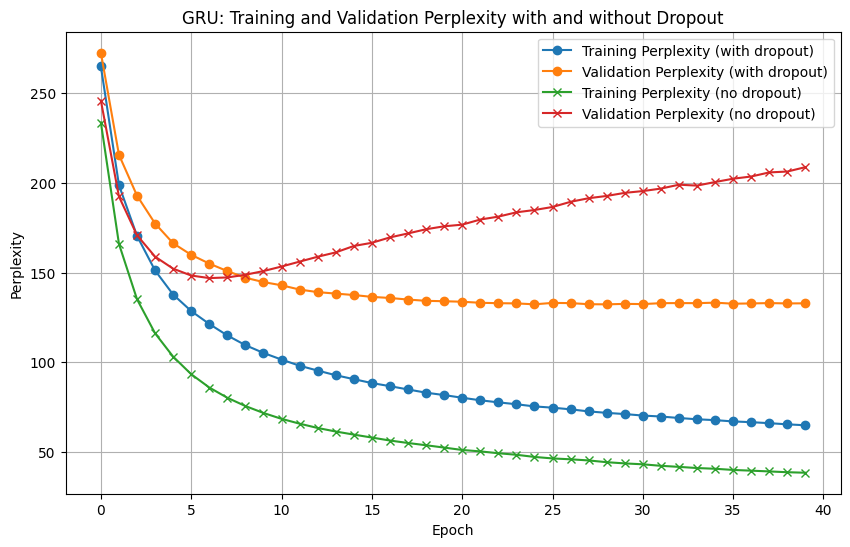

In [ ]:
# Similarly, for perplexity:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(Gru_dropout[2], label='Training Perplexity (with dropout)', marker='o')
plt.plot(Gru_dropout[3], label='Validation Perplexity (with dropout)', marker='o')
plt.plot(Gru_no_dropout[2], label='Training Perplexity (no dropout)', marker='x')
plt.plot(Gru_no_dropout[3], label='Validation Perplexity (no dropout)', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('GRU: Training and Validation Perplexity with and without Dropout')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: save lists to drive

import pickle

# Assuming 'encoded_train', 'train_labels', 'encoded_valid', 'valid_labels', 'word2int' are defined in your existing code.

# Create a dictionary to store the lists
data_to_save = {
    'lstm_train_losses_dropout': per_epoch_train_losses,
    'lstm_valid_losses_dropout': per_epoch_valid_losses,
    'lstm_train_perplexities_dropout': per_epoch_train_perplexities,
    'lstm_valid_perplexities_dropout': per_epoch_valid_perplexities,
    'lstm_train_losses_no_dropout': no_dropout[0],
    'lstm_valid_losses_no_dropout': no_dropout[1],
    'lstm_train_perplexities_no_dropout': no_dropout[2],
    'lstm_valid_perplexities_no_dropout': no_dropout[3],
    'gru_train_losses_dropout': Gru_dropout[0],
    'gru_valid_losses_dropout': Gru_dropout[1],
    'gru_train_perplexities_dropout': Gru_dropout[2],
    'gru_valid_perplexities_dropout': Gru_dropout[3],
    'gru_train_losses_no_dropout': Gru_no_dropout[0],
    'gru_valid_losses_no_dropout': Gru_no_dropout[1],
    'gru_train_perplexities_no_dropout': Gru_no_dropout[2],
    'gru_valid_perplexities_no_dropout': Gru_no_dropout[3],
}

# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/language_model_data.pkl'

# Save the dictionary to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(data_to_save, file)

print(f"Data saved to {file_path}")


# Example of how to load the data later
# with open(file_path, 'rb') as file:
#     loaded_data = pickle.load(file)

# encoded_train = loaded_data['encoded_train']
# # ... load other variables

Data saved to /content/drive/My Drive/language_model_data.pkl


In [ ]:
# prompt: load models and evaluate on test data
# load like this:
# checkpoint_path = "Perplexity_Comparasion_RNN/models/checkpoints/LSTM_dropout_0.3/best_validation_model.pt"
# model = hw2LSTM(batch_size, seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p, device, rnn_type="LSTM", checkpoint=checkpoint_path)
# model.eval()  # Set the model to evaluation mode
# for each model

def evaluate(val_x, val_y, model, batch_size, device):
    valid_losses = []
    valid_perplexities_avarage = []
    val_dataset = SequenceDataset(torch.from_numpy(val_x), torch.from_numpy(val_y), model.seq_length, batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    model.eval()
    val_h = init_hidden(model,batch_size,model.n_layers,model.hidden_dim)
    # Iterate throught validation data
    for inputs, labels in val_loader:
        # if inputs.shape[0] != batch_size or labels.shape[0] != batch_size:
        #     continue
        if model.rnn_type == "LSTM":
          val_h = tuple([each.detach() for each in val_h])
        elif model.rnn_type == "GRU":
          val_h = val_h.detach()
        inputs, labels = inputs.to(device), labels.to(device)
        out, val_h = model(inputs, val_h)
        labels = labels.view(-1)
        val_loss = criterion(out, labels)
        valid_losses.append(val_loss.item())

        valid_perplexity = torch.exp(val_loss).item()
        valid_perplexities_avarage.append(valid_perplexity)

    # valid_losses.append(valid_loss/len(val_loader))
    avarage_valid_loss = sum(valid_losses)/len(valid_losses)
    average_valid_perplexity = sum(valid_perplexities_avarage)/len(valid_perplexities_avarage)
    return average_valid_perplexity

import torch

checkpoint_paths = {
    "LSTM_dropout_0.3": "/content/drive/MyDrive/Deep Learning/models/checkpoints/LSTM_dropout_0.3/best_validation_model.pt",
    "LSTM_no_dropout": "/content/drive/MyDrive/Deep Learning/models/checkpoints/LSTM_no_dropout/best_validation_model.pt",  # Replace with the actual path
    "GRU_dropout_0.3": "/content/drive/MyDrive/Deep Learning/models/checkpoints/GRU_dropout_0.3/best_validation_model.pt",    # Replace with the actual path
    "GRU_no_dropout": "/content/drive/MyDrive/Deep Learning/models/checkpoints/GRU_no_dropout/best_validation_model.pt"      # Replace with the actual path
}

# Assuming hw2LSTM, batch_size, seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p, and device are defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_name, checkpoint_path in checkpoint_paths.items():
    print(f"Evaluating model: {model_name}")
    try:
        if "LSTM" in model_name:
          rnn_type = "LSTM"
          dropout_p = 0.3 if "dropout" in model_name else 0
        else: #GRU
          rnn_type = "GRU"
          dropout_p = 0.3 if "dropout" in model_name else 0
        model = hw2LSTM(batch_size, seq_length, hidden_dim, n_layers, vocab_size, embedding_dim, dropout_p, device, rnn_type=rnn_type, checkpoint=checkpoint_path)
        model.eval()  # Set the model to evaluation mode

        perplexity = evaluate(encoded_test, test_labels, model, batch_size, device)
        print(f"Perplexity of {model_name}: {perplexity}")
        print("Evaluation complete.")

    except FileNotFoundError:
        print(f"Error: Checkpoint file not found for {model_name} at {checkpoint_path}")
    except Exception as e:
        print(f"An error occurred during evaluation of {model_name}: {e}")